<a href="https://colab.research.google.com/github/chenshuo/notes/blob/master/notebooks/DSP_Labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital signal processing beginner's labs

_A companion notebook to undergraduate digital signal processing courses._

Author: Shuo Chen (chenshuo _at_ chenshuo.com)

Latest version: http://chenshuo.com/data/DSP_Labs.ipynb  
https://github.com/chenshuo/notes/blob/master/notebooks/DSP_Labs.ipynb


**Links**

* [Allen Downey - ThinkDSP](https://github.com/AllenDowney/ThinkDSP)
  * [Introduction to Digital Signal Processing - PyCon 2018](https://www.youtube.com/watch?v=SrJq2AzXZME)
* [StrathSDR - DSP Introductory Notebooks](https://github.com/strath-sdr/dsp_notebooks)
* [Berkeley EE123: Digital Signal Processing - 2019 Spring](https://sites.google.com/berkeley.edu/ee123-sp19/home?authuser=0)
  * [EE120 Labs](https://github.com/dominiccarrano/ee-120-labs)
* [Purdue ECE438: Digital Signal Processing with Applications - Spring 2022](https://engineering.purdue.edu/~ece438/)
  * [Labs](https://engineering.purdue.edu/VISE/ee438L/)



In [ ]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 5.5.0
ipykernel        : 4.10.1
ipywidgets       : 7.7.1
jupyter_client   : 5.3.5
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.6.6
nbconvert        : 5.6.1
nbformat         : 5.4.0
notebook         : 5.3.1
qtconsole        : 5.3.1
traitlets        : 5.1.1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import librosa as rosa
import librosa.display
from IPython.display import Audio

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

np.set_printoptions(suppress=True)

In [18]:
def draw_pzmap(dlti):
  plt.plot(np.real(dlti.zeros), np.imag(dlti.zeros), 'o', mfc='none')
  plt.plot(np.real(dlti.poles), np.imag(dlti.poles), 'x')
  w = np.linspace(0, 2*np.pi)
  plt.plot(np.cos(w), np.sin(w), 'y--')
  limits = plt.axis("equal")
  plt.grid()

def draw_resp_stem(x, y):
  plt.stem(x, use_line_collection=True)
  (markerline, _, _) = plt.stem(y, linefmt='r', markerfmt='ro', use_line_collection=True)
  markerline.set_markerfacecolor('none')

# Lab1: Discrete LTI systems

**Weighted Moving Average**

* Memoryless

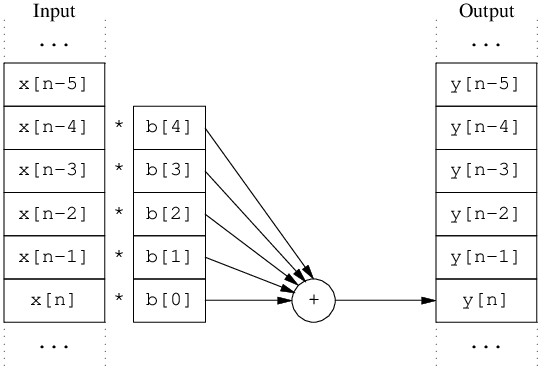

$$\begin{aligned}
  y[n] &= \sum_{i=0}^{L}b[i] x[n-i] \\
       & = b[0]x[n] + b[1]x[n-1] + \cdots + b[L]x[n-L]
\end{aligned} $$

* [scipy.signal.convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html), [oaconvolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.oaconvolve.html), [fftconvolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html)
* [scipy.signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)
* [scipy.signal.dlsim](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.dlsim.html)
* [scipy.signal.dlti.output](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.dlti.output.html)
---

In [ ]:
from collections.abc import Sequence

def direct_wma(b : Sequence, x : Sequence) -> Sequence:
  y = np.zeros(len(x))
  x_pad = np.concatenate((np.zeros(len(b)-1), x))
  b_rev = np.array(b[::-1], dtype='d')
  for i in range(len(x)):
    y[i] = np.dot(b_rev, x_pad[i : i + len(b)])
  return y

b = [2, 1]
x = np.arange(10) 
y = direct_wma(b, x)
print(np.array([x, y]).T)

[[ 0.  0.]
 [ 1.  2.]
 [ 2.  5.]
 [ 3.  8.]
 [ 4. 11.]
 [ 5. 14.]
 [ 6. 17.]
 [ 7. 20.]
 [ 8. 23.]
 [ 9. 26.]]


In [ ]:
b = [2, 1]
x = np.arange(10, dtype='d')
y = signal.lfilter(b, [1], x)
print(np.array([x, y]).T)

[[ 0.  0.]
 [ 1.  2.]
 [ 2.  5.]
 [ 3.  8.]
 [ 4. 11.]
 [ 5. 14.]
 [ 6. 17.]
 [ 7. 20.]
 [ 8. 23.]
 [ 9. 26.]]


**Recursive, or ladder**

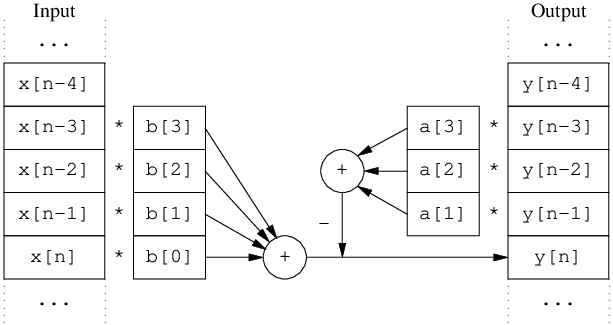

$$\begin{aligned}
y[n] = &\sum_{i=0}^{L}b[i]x[n-i] - \sum_{i=1}^{M}a[i\,]y[n-i\,] \\
 = & \  b[0]x[n] + b[1]x[n-1] + \cdots + b[L]x[n-L] \\
        &-(a[1]y[n-1]+a[2]y[n-2]+\cdots+a[M]y[n-M])
\end{aligned}$$

* [scipy.signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)
* [scipy.signal.dlsim](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.dlsim.html)
* [scipy.signal.dlti.output](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.dlti.output.html)

What if `x` is *Iterable*, not *Sequence*?

Realtime DSP.

In [ ]:
# Pseudo code only

def iterative_dlti(b : list, a : list, x_in : Iterable) -> Iterable:
  x_vec = np.zeros(len(b))  # circular buffer
  y_vec = np.zeros(len(a))  # circular buffer
  for u in x_in:
    # update x_vec
    yn = np.dot(x_vec, b) - np.dot(y_vec, a)
    # update y_vec
    yield yn

for y in iterative_dlti(b, a, x):
  output(y)

## Moving average

Julius O. Smith, _Introduction to Digital Filters with Audio Applications_, http://ccrma.stanford.edu/~jos/filters/

Chapter 1: https://ccrma.stanford.edu/~jos/filters/Simplest_Lowpass_Filter.html

$y[n] = \frac{1}{2}x[n]+\frac{1}{2}x[n-1]$

In [ ]:
b = [1/2, 1/2]

x = np.arange(11)
y = signal.lfilter(b, [1], x)  # or signal.convolve(b, x)
print(np.array([x, y]).T)

[[ 0.   0. ]
 [ 1.   0.5]
 [ 2.   1.5]
 [ 3.   2.5]
 [ 4.   3.5]
 [ 5.   4.5]
 [ 6.   5.5]
 [ 7.   6.5]
 [ 8.   7.5]
 [ 9.   8.5]
 [10.   9.5]]


[scipy.signal.dlti](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.dlti.html) Discrete-time linear time invariant system 

Zeros: [-1.]
Poles: []


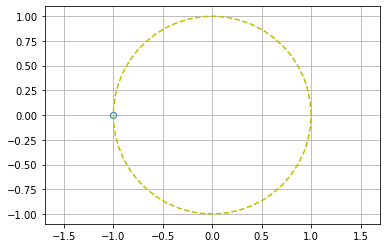

In [ ]:
dlti = signal.dlti(b, [1])
print('Zeros:', dlti.zeros)
print('Poles:', dlti.poles)
draw_pzmap(dlti)

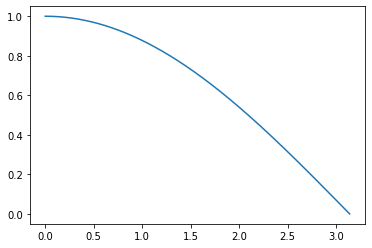

In [ ]:
w, mag = dlti.freqresp()
plt.plot(w, np.abs(mag))

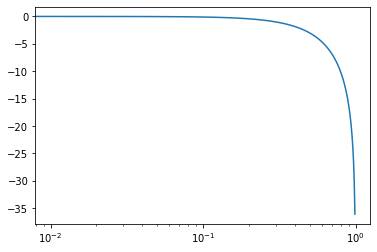

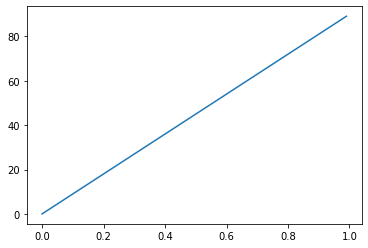

In [ ]:
w, mag, phase = dlti.bode()
plt.semilogx(w/np.pi, mag)
plt.figure(2)
plt.plot(w/np.pi,phase)

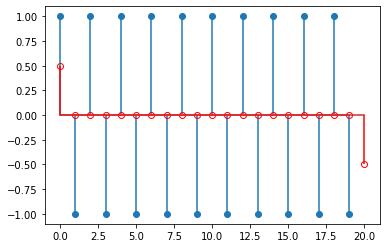

In [ ]:
w = np.arange(20) * np.pi
x = np.cos(w)  # [1, -1, 1, -1, 1, -1, ...]
y = np.convolve(b, x)

plt.stem(x, use_line_collection=True)
plt.stem(y, linefmt='r', markerfmt='ro', use_line_collection=True)

In [ ]:
@interact(f = (0, 1, 0.02))
def resp(f = 0.02):
  t = np.linspace(0, 1, 101)
  x = np.cos(t * 2*np.pi * f * 100)
  plt.plot(t, x)
  y = signal.lfilter([1/2, 1/2], [1], x)
  plt.plot(t, y)
  plt.show()

interactive(children=(FloatSlider(value=0.02, description='f', max=1.0, step=0.02), Output()), _dom_classes=('…

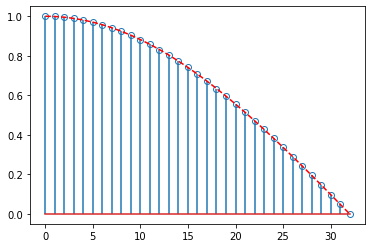

In [ ]:
fft = np.fft.rfft([1/2, 1/2], n=64)  # zero padding
(marker, _, _) = plt.stem(np.abs(fft), use_line_collection=True)
marker.set_markerfacecolor('none')

fr = dlti.freqresp(w=np.linspace(0, 1, len(fft)) * np.pi)[1]
plt.plot(np.abs(fr), 'r--')

**n = 3**

$y[n] = \frac{1}{3}x[n] + \frac{1}{3}x[n-1] + \frac{1}{3}x[n-2]$

min_mag = -84.37 dB


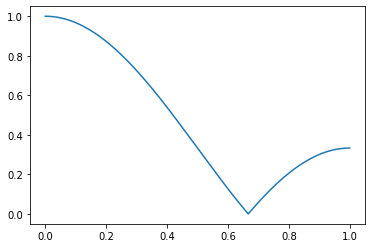

In [ ]:
b3 = [1/3, 1/3, 1/3]
dlti3 = signal.dlti(b3, [1])

w, mag = dlti3.freqresp()
plt.plot(w/np.pi, np.abs(mag))
print('min_mag = %.2f dB' % (20 * np.log10(np.min(np.abs(mag)))))

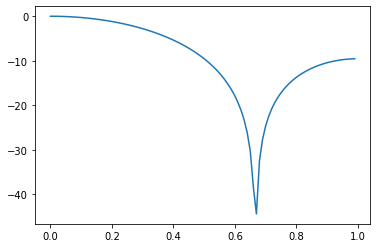

In [ ]:
w, mag, phase = dlti3.bode()
plt.plot(w/np.pi, mag)

[ 120. -120.]


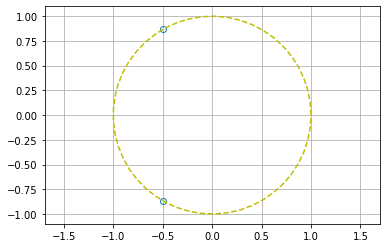

In [ ]:
draw_pzmap(dlti3)
print(np.angle(dlti3.zeros)/np.pi*180)

[ 1.  -0.5 -0.5  1.  -0.5 -0.5  1.  -0.5 -0.5  1. ]


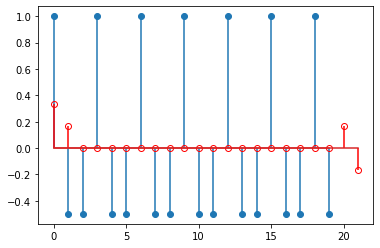

In [ ]:
t = np.arange(20)
x = np.cos(t * 2/3 * np.pi)
y = np.convolve(x, b3)

draw_resp_stem(x, y)
print(x[0:10])

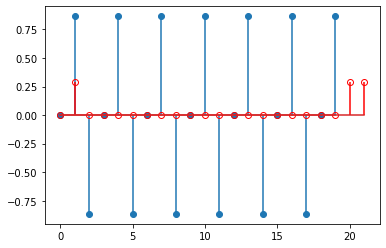

In [ ]:
t = np.arange(20)
x = np.sin(t * 2/3 * np.pi)
y = np.convolve(x, b3)
draw_resp_stem(x, y)

# x = [1, -1, 0, 1, -1, 0, 1, -1, 0, 1]

In [ ]:
@interact(phase=(0, 90, 5))
def resp(phase=0):
  t = np.arange(15)
  x = np.cos(t * 2/3 * np.pi - phase / 180 * np.pi)
  y = signal.lfilter(b3, [1], x)
  plt.stem(t, x, use_line_collection=True)
  t1 = np.arange(141) / 10
  plt.plot(t1, np.cos(t1 * 2/3 * np.pi - phase / 180 * np.pi), 'y--')
  (markerline, stemlines, baseline) = plt.stem(t, y, linefmt='r', markerfmt='ro', use_line_collection=True)
  markerline.set_markerfacecolor('none')

interactive(children=(IntSlider(value=0, description='phase', max=90, step=5), Output()), _dom_classes=('widge…

**n = 4**

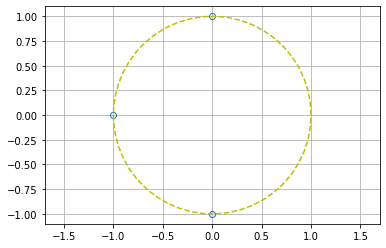

In [ ]:
b4 = np.ones(4) / 4.0
dlti4 = signal.dlti(b4, [1])
draw_pzmap(dlti4)

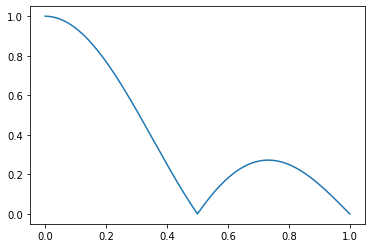

In [ ]:
w, mag = dlti4.freqresp()
plt.plot(w/np.pi, np.abs(mag))

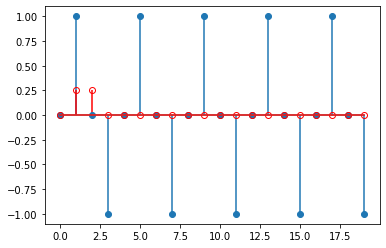

In [ ]:
x = np.array([0, 1, 0, -1] * 5)
y = signal.lfilter(b4, [1], x)

draw_resp_stem(x, y)

In [ ]:
@interact(phase=(0, 90, 5))
def resp(phase=0):
  t = np.arange(16)
  x = np.cos(t * 1/2 * np.pi - phase / 180 * np.pi)
  y = signal.lfilter(b4, [1], x)
  plt.stem(t, x, use_line_collection=True)
  t1 = np.arange(151) / 10
  plt.plot(t1, np.cos(t1 * 1/2 * np.pi - phase / 180 * np.pi), 'y--')
  (markerline, stemlines, baseline) = plt.stem(t, y, linefmt='r', markerfmt='ro', use_line_collection=True)
  markerline.set_markerfacecolor('none')

interactive(children=(IntSlider(value=0, description='phase', max=90, step=5), Output()), _dom_classes=('widge…

## Differentiator

$y[n]=x[n]-x[n-1]$

In [ ]:
bd = [1, -1]
x = np.arange(10, dtype='d')  ** 2 
print(x)
y = signal.lfilter(bd, [1], x)
print(y)
z = signal.lfilter(bd, [1], y)
print(z)
z = signal.lfilter(bd, [1], z)
print(z)

[ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
[ 0.  1.  3.  5.  7.  9. 11. 13. 15. 17.]
[0. 1. 2. 2. 2. 2. 2. 2. 2. 2.]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


Zeros: [1.]
Poles: []


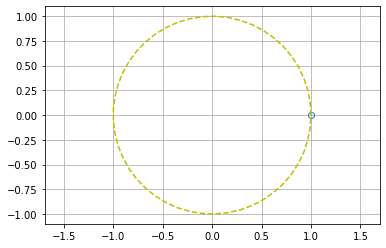

In [ ]:
dlti = signal.dlti(bd, [1])
zeros = dlti.zeros
print('Zeros:', zeros)
print('Poles:', dlti.poles)
draw_pzmap(dlti)

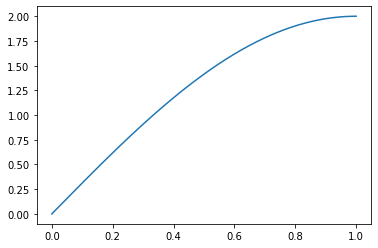

In [ ]:
w, mag = dlti.freqresp()
plt.plot(w/np.pi, np.abs(mag))

**eigenfunction**

In [ ]:
x = 2.0 ** np.arange(14)

y = signal.lfilter(bd, [1], x)
z = signal.lfilter(bd, [1], y)
w = signal.lfilter(bd, [1], z)
np.array([x, y, z, w]).T

array([[   1.,    1.,    1.,    1.],
       [   2.,    1.,    0.,   -1.],
       [   4.,    2.,    1.,    1.],
       [   8.,    4.,    2.,    1.],
       [  16.,    8.,    4.,    2.],
       [  32.,   16.,    8.,    4.],
       [  64.,   32.,   16.,    8.],
       [ 128.,   64.,   32.,   16.],
       [ 256.,  128.,   64.,   32.],
       [ 512.,  256.,  128.,   64.],
       [1024.,  512.,  256.,  128.],
       [2048., 1024.,  512.,  256.],
       [4096., 2048., 1024.,  512.],
       [8192., 4096., 2048., 1024.]])

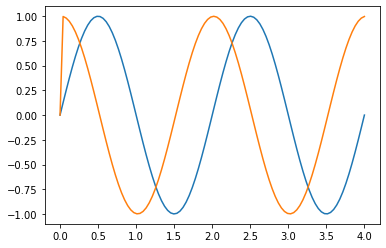

In [ ]:
t = np.linspace(0, 1,100) * 4 * np.pi
x = np.sin(t)
y = signal.lfilter(bd, [1], x)
plt.plot(t/np.pi, x)
plt.plot(t/np.pi, y/(t[1]-t[0]))

## Recursive

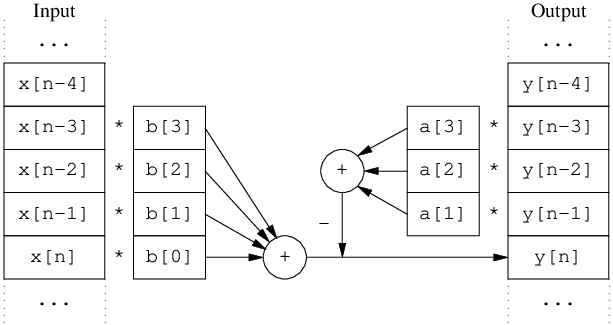

$$y[n] = \sum_{i=0}^{L}b[i]x[n-i] - \sum_{i=1}^{M}a[i]y[n-i]$$

### Accumulator, integrator

$y[n] = x[n] + y[n-1]$

$H(z)=\dfrac{1}{1-z^{-1}}$

Zeros: []
Poles: [1.]


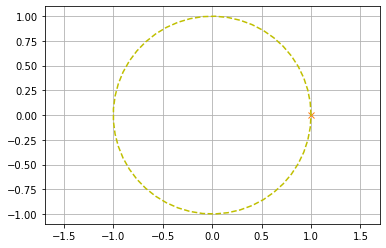

In [ ]:
dlti = signal.dlti([1], [1, -1])
draw_pzmap(dlti)
print('Zeros:', dlti.zeros)
print('Poles:', dlti.poles)

In [ ]:
b = [1]
a = [1, -1]
x = np.zeros(11)
x[1] = 1
print(x)
y = signal.lfilter(b, a, x=x)
print(y)
z = signal.lfilter(b, a, y)
print(z)
w = signal.lfilter(b, a, z)
print(w)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  3.  6. 10. 15. 21. 28. 36. 45. 55.]


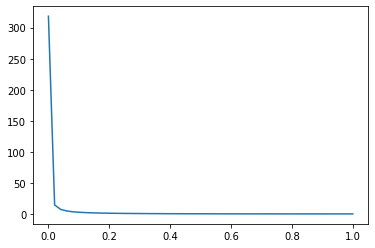

In [ ]:
w, mag = dlti.freqresp(w=np.linspace(np.pi/1000, np.pi))
plt.plot(w/np.pi, np.abs(mag))

<StemContainer object of 3 artists>

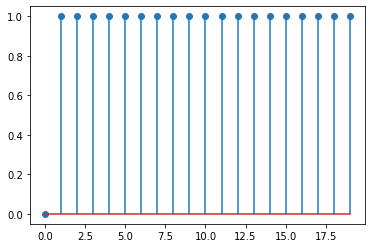

In [ ]:
t, y = dlti.impulse(n=20)
plt.stem(t, y[0], use_line_collection=True)

<StemContainer object of 3 artists>

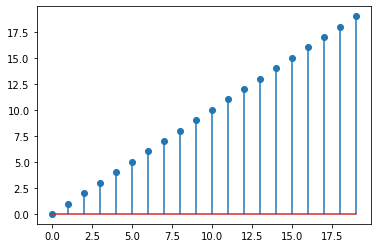

In [ ]:
t, y = dlti.step(n=20)
plt.stem(t, y[0], use_line_collection=True)

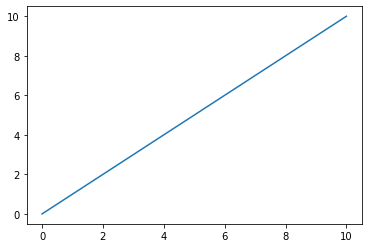

In [ ]:
w3 = signal.lfilter(b, a, w)
plt.plot(z)   # linear
plt.plot(w)   # quadratic
plt.plot(w3)  # 3-order

**eigenfunction**

In [ ]:
x = 2.0 ** np.arange(11)
y = signal.lfilter(b, a, x, zi=x[0:1])[0]
z = signal.lfilter(b, a, y, zi=y[0:1])[0]
w = signal.lfilter(b, a, z, zi=z[0:1])[0]
np.array([x, y, z, w]).T

array([[   1.,    2.,    4.,    8.],
       [   2.,    4.,    8.,   16.],
       [   4.,    8.,   16.,   32.],
       [   8.,   16.,   32.,   64.],
       [  16.,   32.,   64.,  128.],
       [  32.,   64.,  128.,  256.],
       [  64.,  128.,  256.,  512.],
       [ 128.,  256.,  512., 1024.],
       [ 256.,  512., 1024., 2048.],
       [ 512., 1024., 2048., 4096.],
       [1024., 2048., 4096., 8192.]])

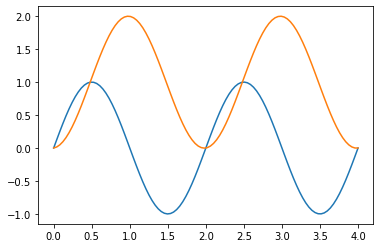

In [ ]:
t = np.linspace(0, 1,100) * 4 * np.pi
x = np.sin(t)
y = signal.lfilter(b, a, x)
plt.plot(t/np.pi, x)
plt.plot(t/np.pi, y*(t[1]-t[0]))

模拟反向积分器

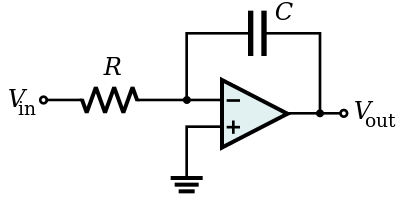



$$V_\text{out}(t_1) = V_\text{out}(t_0) - \frac{1}{RC} \int_{t_0}^{t_1} V_\text{in}(t) \,dt$$

* R = 1 MΩ
* C = 1 μF
* Vin = 1 V (DC)
* Ir = 1 μA
* Vout = -t V
* Vs = ±15V

那么积十几秒就会饱和。

OPA627
* Vos = 100 μV
* Ib = 1 pA

159.2356687898089


### Compound interest

$y[n] = x[n] + a y[n-1]$

$H(z)=\dfrac{1}{1-az^{-1}}$

Zeros: []
Poles: [1.1]


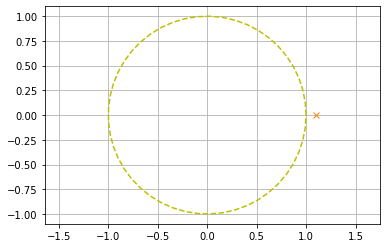

In [ ]:
a = 1.1  # 年投资回报率 10%

dlti = signal.dlti([1], [1, -a])
draw_pzmap(dlti)
print('Zeros:', dlti.zeros)
print('Poles:', dlti.poles)

<StemContainer object of 3 artists>

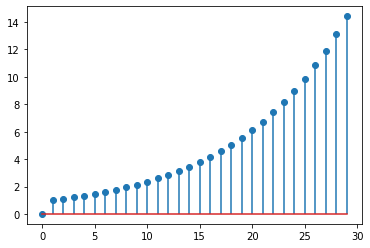

In [ ]:
t, y = dlti.impulse(n=30)
plt.stem(t, y[0], use_line_collection=True)

<StemContainer object of 3 artists>

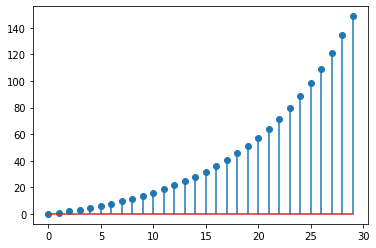

In [ ]:
t, y = dlti.step(n=30)
plt.stem(t, y[0], use_line_collection=True)

**零状态响应**

年息 1.2%，月息 0.1%，每月存 1000。$a = 1+ 1.2\% / 12 = 1.001$

In [ ]:
rate = 1.2
a = 1.0 + rate / 100 / 12

x = np.ones(12) * 1000
y = signal.lfilter([1], [1, -a], x)
print(np.array([x, np.round(y, 2)]).T)

[[ 1000.    1000.  ]
 [ 1000.    2001.  ]
 [ 1000.    3003.  ]
 [ 1000.    4006.  ]
 [ 1000.    5010.01]
 [ 1000.    6015.02]
 [ 1000.    7021.04]
 [ 1000.    8028.06]
 [ 1000.    9036.08]
 [ 1000.   10045.12]
 [ 1000.   11055.17]
 [ 1000.   12066.22]]


**零输入响应**

年息 1.2%，月息 0.1%，起始存款 10000。

In [ ]:
rate = 1.2
a = 1.0 + rate / 100 / 12
y0 = 10000.0

x = np.zeros(13) * 0.0
y, yn = signal.lfilter([1], [1, -a], x, zi=[y0])
np.set_printoptions(suppress=True)
print(np.array([np.arange(len(x)), np.round(y, 2)]).T)
# print('yn =', np.round(yn, 2))

[[    0.   10000.  ]
 [    1.   10010.  ]
 [    2.   10020.01]
 [    3.   10030.03]
 [    4.   10040.06]
 [    5.   10050.1 ]
 [    6.   10060.15]
 [    7.   10070.21]
 [    8.   10080.28]
 [    9.   10090.36]
 [   10.   10100.45]
 [   11.   10110.55]
 [   12.   10120.66]]


**完全响应**

贷款 20000，年息 3.5%，分 24 期（2 年）偿还，每月还款 864.06。

$p = L\dfrac{c(1+c)^n}{(1+c)^n-1}$, $L=20\,000$, $n = 24$, $c = 3.5\%/12$.

In [ ]:
L = 20000
n = 24
rate = 3.5
c = rate / 100 / 12
p = L * c * np.power(1+c, n) / (np.power(1+c, n) - 1)
print('Monthly payment: %.4f' % p)

Monthly payment: 864.0544


In [ ]:
rate = 3.5
a = 1.0 + rate / 100 / 12
y0 = 20000.0

x = np.concatenate(([0.0], np.ones(24) * -864.06))
y, yn = signal.lfilter([1], [1, -a], x, zi=[y0])
np.set_printoptions(suppress=True)
print(np.array([np.arange(len(x)), np.round(y, 2)]).T)
print('yn =', np.round(yn, 2))

[[    0.   20000.  ]
 [    1.   19194.28]
 [    2.   18386.22]
 [    3.   17575.79]
 [    4.   16763.01]
 [    5.   15947.85]
 [    6.   15130.31]
 [    7.   14310.39]
 [    8.   13488.08]
 [    9.   12663.37]
 [   10.   11836.26]
 [   11.   11006.73]
 [   12.   10174.78]
 [   13.    9340.41]
 [   14.    8503.6 ]
 [   15.    7664.35]
 [   16.    6822.66]
 [   17.    5978.51]
 [   18.    5131.89]
 [   19.    4282.81]
 [   20.    3431.25]
 [   21.    2577.21]
 [   22.    1720.68]
 [   23.     861.65]
 [   24.       0.11]]
yn = [0.11]


### Exponential moving average

$y[n] = ax[n]+(1-a)y[n-1]$

$H(z) = \dfrac{a}{1 - (1-a)z^{-1}}$

证明：对于 x[n] = constant, y[n] 收敛到 constant。

$H(1) = \dfrac{a}{1-(1-a)} = \dfrac{a}{a} = 1$, if $a \ne 0$

Zeros: []
Poles: [0.2]


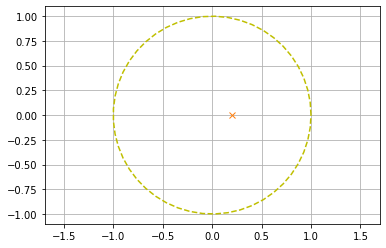

In [ ]:
a = 0.8

dlti = signal.dlti([a], [1, a-1])
draw_pzmap(dlti)
print('Zeros:', dlti.zeros)
print('Poles:', dlti.poles)

In [ ]:
@interact(a=(0.1, 0.9, 0.1))
def ema(a):
  dlti = signal.dlti([a], [1, a-1])
  t, imp = dlti.impulse()
  plt.stem(t, imp[0], use_line_collection=True)
  plt.figure(2)
  t, step = dlti.step()
  plt.stem(t, step[0], use_line_collection=True)

interactive(children=(FloatSlider(value=0.5, description='a', max=0.9, min=0.1), Output()), _dom_classes=('wid…

In [ ]:
@interact(a=(0.1, 0.9, 0.1))
def ema(a):
  dlti = signal.dlti([a], [1, a-1])
  draw_pzmap(dlti)
  plt.figure(2)
  w, mag = dlti.freqresp()
  plt.plot(w/np.pi, np.abs(mag))
  plt.ylim(0, 1.1)

interactive(children=(FloatSlider(value=0.5, description='a', max=0.9, min=0.1), Output()), _dom_classes=('wid…

**How does TCP calculates RTT**

* [RFC793](https://www.rfc-editor.org/rfc/rfc793) Transmission Control Protocol, 1981 Sept.
* [Jacobson88](https://ee.lbl.gov/papers/congavoid.pdf) Congestion Avoidance and Control, 1988 Nov.
* [RFC1122](https://www.rfc-editor.org/rfc/rfc1122.html) 1989 Oct.
* [RFC2988](https://www.rfc-editor.org/rfc/rfc2988.html) 2000 Nov.
* [RFC6298](https://www.rfc-editor.org/rfc/rfc6298.html) Computing TCP's Retransmission Timer, 2011 June.

**RFC 793**

$$newRTT = \alpha \cdot oldRTT + (1-\alpha) \cdot newRTTsample$$

$$\alpha = 0.9$$

$$y[n] = \alpha \cdot y[n-1] + (1-\alpha) x[n]$$

I found a typo in RFC793 in 2020-10. https://www.rfc-editor.org/errata/eid6305

**RFC 6298**

```
   (2.2) When the first RTT measurement R is made, the host MUST set

            SRTT <- R
            RTTVAR <- R/2
            RTO <- SRTT + max (G, K*RTTVAR)

         where K = 4.

   (2.3) When a subsequent RTT measurement R' is made, a host MUST set

            RTTVAR <- (1 - beta) * RTTVAR + beta * |SRTT - R'|
            SRTT <- (1 - alpha) * SRTT + alpha * R'

         The value of SRTT used in the update to RTTVAR is its value
         before updating SRTT itself using the second assignment.  That
         is, updating RTTVAR and SRTT MUST be computed in the above
         order.

         The above SHOULD be computed using alpha=1/8 and beta=1/4 (as
         suggested in [JK88]).

         After the computation, a host MUST update
         RTO <- SRTT + max (G, K*RTTVAR)
```

$$SRTT \gets (1-\alpha)\cdot SRTT + \alpha \cdot Rsample $$

$$\alpha = \frac{1}{8}$$

$$y[n] = \alpha x[n] + (1-\alpha) y[n-1]$$

### Fibonacci sequence

$y[n] = y[n-1] + y[n-2]$, with $y[-1] = 1$

$H(z) = \dfrac{1}{1-z^{-1}-z^{-2}}$

Zeros: []
Poles: [ 1.61803399 -0.61803399]


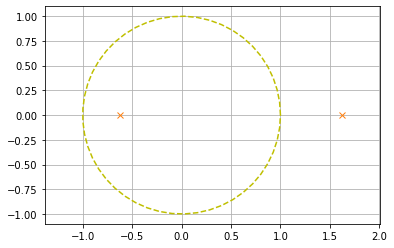

In [ ]:
dlti = signal.dlti([1], [1, -1, -1])
draw_pzmap(dlti)
print('Zeros:', dlti.zeros)
print('Poles:', dlti.poles)

In [ ]:
dlti.impulse(n=15)[1]

(array([[  0.],
        [  0.],
        [  1.],
        [  1.],
        [  2.],
        [  3.],
        [  5.],
        [  8.],
        [ 13.],
        [ 21.],
        [ 34.],
        [ 55.],
        [ 89.],
        [144.],
        [233.]]),)

### Second order digital sinusoidal oscillator

$y[n]=2\cos(w)y[n-1]-y[n-2]$, with $y[-1] = \sin(w)$

$H(z) = \dfrac{1}{1-2\cos(w)z^{-1}+z^{-2}}$

* Digital resonator
https://ccrma.stanford.edu/~jos/pdf/GordonAndSmith86.pdf
* [MIT OCW 6.003](https://ocw.mit.edu/courses/6-003-signals-and-systems-fall-2011/pages/readings/) notes [Chap 6 - The perfect (sine) wave](https://ocw.mit.edu/courses/6-003-signals-and-systems-fall-2011/resources/mit6_003f11_chap6/) using [leapfrog method](https://en.wikipedia.org/wiki/Leapfrog_integration).

Zeros: []
Poles: [0.95105652+0.30901699j 0.95105652-0.30901699j]
Poles amp: [1. 1.] angle: [ 18. -18.]


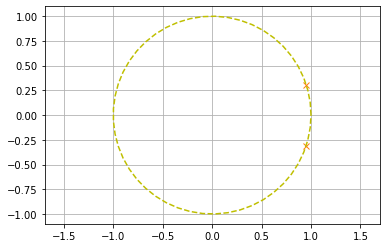

In [ ]:
w = np.pi / 10
dlti = signal.dlti([1], [1, -2 * np.cos(w), 1])
draw_pzmap(dlti)
print('Zeros:', dlti.zeros)
print('Poles:', dlti.poles)
print('Poles amp:', np.abs(dlti.poles), "angle:", np.angle(dlti.poles) / np.pi * 180)

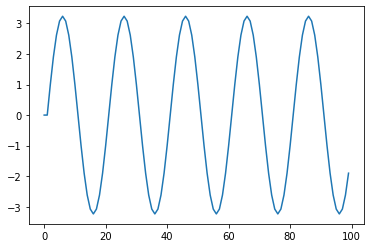

In [ ]:
y = dlti.impulse()[1]
plt.plot(y[0])

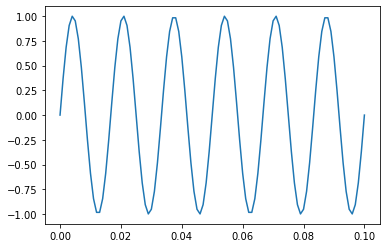

In [ ]:
# This is numerically instable

fs = 1000
f = 60
w = 2*np.pi*f/fs
c = np.cos(w)
a = [1, -2*c, 1]
n = 101
x = np.zeros(n) * 0.0
y0 = np.sin(w)
y, yn = signal.lfilter([1], a, x, zi=[0, y0])
t = np.arange(n)/fs
plt.plot(t, y)

In [ ]:
print(max(y), min(y))

0.9980267284282738 -0.9980267284282742


In [ ]:
w=2*np.pi*30/1000
c = np.cos(w)
c2=1/(np.exp(1j*w)-np.exp(3j*w))
c1=-c2*np.exp(4j*w)
print(w)
print(c1, c2)
print(np.abs(c1)*2)

In [ ]:
w=2*np.pi*30/1000
c = (np.exp(1j*w)-np.exp(3j*w))
print(c, np.abs(c) )

Why not use `sin()`/`cos()`?

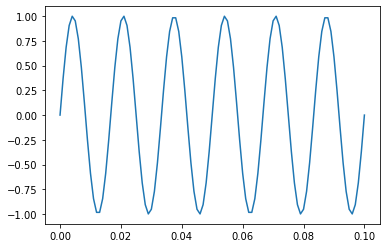

In [ ]:
fs = 1000
f = 60
n = 101
t = np.arange(n) / fs
y1 = np.sin(2 * np.pi * f * t)
plt.plot(t, y1)

In [ ]:
print(y - y1)
print(sum(np.abs(y-y1)))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.33066907e-16  6.66133815e-16  1.22124533e-15  1.38777878e-15
  1.72084569e-15  1.41553436e-15  1.66533454e-15  9.99200722e-16
  5.55111512e-16 -4.44089210e-16 -1.11022302e-15 -1.66533454e-15
 -2.60902411e-15 -3.30291350e-15 -1.88737914e-15 -1.66533454e-15
 -8.88178420e-16  6.66133815e-16  1.88737914e-15  2.77555756e-15
  4.71844785e-15  4.62860957e-15  3.83026943e-15  2.55351296e-15
  1.11022302e-15 -3.33066907e-16 -1.77635684e-15 -3.88578059e-15
 -4.66293670e-15 -4.80171458e-15 -5.96744876e-15 -4.55191440e-15
 -1.66533454e-15 -1.11022302e-16  1.88737914e-15  3.66373598e-15
  6.43929354e-15  7.24420524e-15  6.99440506e-15  4.21884749e-15
  3.88578059e-15  9.99200722e-16 -7.77156117e-16 -3.55271368e-15
 -6.88338275e-15 -6.49480469e-15 -8.25801842e-15 -5.49560397e-15
 -5.10702591e-15 -1.55431223e-15  7.77156117e-16  4.21884749e-15
  5.88418203e-15  8.77076189e-15  1.09634524e-14  8.32667268e-15
  4.88498131e-15  3.44169

## Summary

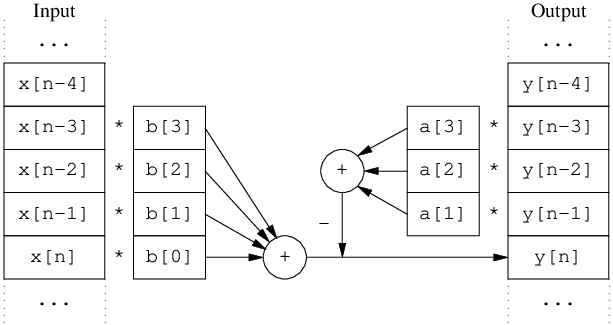

$$\begin{aligned}
y[n] = &\sum_{i=0}^{L}b[i]x[n-i] - \sum_{i=1}^{M}a[i\,]y[n-i\,] \\
 = & \  b[0]x[n] + b[1]x[n-1] + \cdots + b[L]x[n-L] \\
        &-(a[1]y[n-1]+a[2]y[n-2]+\cdots+a[M]y[n-M])
\end{aligned}$$

# Lab2: Filtering

https://github.com/chipmuenk/pyfda

## Review DLTI

SISO DLTI system 可由 $\mathbf{a}, \mathbf{b}$ 两个向量，总共 $L+M+1$ 个系数完全定义：

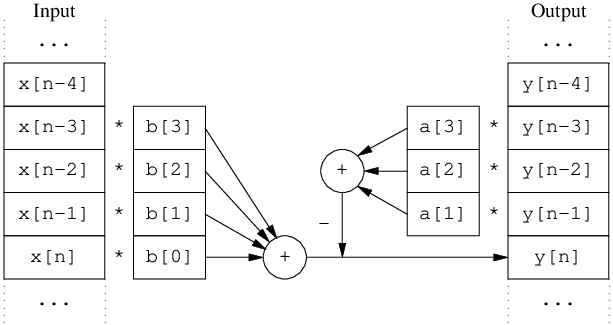

$$\begin{aligned}
y[n] = &\sum_{i=0}^{L}b[i]x[n-i] - \sum_{i=1}^{M}a[i\,]y[n-i\,] \\
 = & \  b[0]x[n] + b[1]x[n-1] + \cdots + b[L]x[n-L] \\
        &-(a[1]y[n-1]+a[2]y[n-2]+\cdots+a[M]y[n-M])
\end{aligned}$$

**模型之间的相互转换**

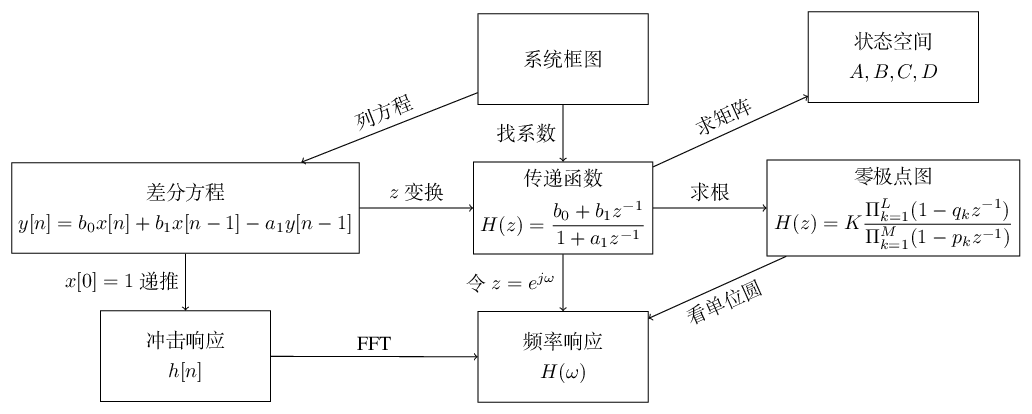

$$\begin{aligned}
y[n] &= \sum_{i=0}^{L}b_ix[n-i\,] - \sum_{i=1}^{M}a_iy[n-i\,] \\
     &=  \  b_0x[n] + b_1x[n-1] + \cdots + b_Lx[n-L] \\
     & \quad   -(a_1y[n-1]+a_2y[n-2]+\cdots+a_My[n-M])\\[3mm]
H(z) &= \frac{\sum_{i=0}^{L}b_iz^{-i}}{1+ \sum_{i=1}^{M}a_iz^{-i}} \\
     &= \frac{b_0 + b_1z^{-1}+b_2z^{-2}+\cdots+b_Lz^{-L}}{1+a_1z^{-1}+a_2z^{-2}+\cdots+a_Mz^{-M}}\\[3mm]
H(z) &= b_0\frac{\prod_{i=1}^L(1-z_iz^{-1})}{\prod_{i=1}^M(1-p_iz^{-1})} \\
     &=b_0\frac{(1-z_1z^-1)(1-z_2z^{-1})\cdots(1-z_Lz^{-1})}{(1-p_1z^-1)(1-p_2z^{-1})\cdots(1-z_Mz^{-1})}
\end{aligned}$$

https://web.eecs.umich.edu/~fessler/course/451/l/pdf/c3.pdf


## Convolution

For LTI systems:

$Output = Convolve(Input, ImpulseResponse)$

Acoustic Impulse Responses

* [Allen Downey - ThinkDSP](https://github.com/AllenDowney/ThinkDSP)
  * Execrise 10.2 _Simulate the sound of your recording in the space where the impulse response was measured, ..._
* [Allen Downey - Introduction to Digital Signal Processing - PyCon 2018](https://www.youtube.com/watch?v=SrJq2AzXZME)

A room (e.g. concert hall) behaves like a LTI system for sound.
Here _Time-Invariant_ is assumed.

 * [Open Air Library](https://www.openairlib.net/) - acoustic impulse responses
 * [PyRoomAcoustics](https://pyroomacoustics.readthedocs.io/en/pypi-release/index.html) - Room Acoustics Simulation

Librosa

* https://medium.com/@patrickbfuller/librosa-a-python-audio-libary-60014eeaccfb
* https://www.youtube.com/watch?v=MhOdbtPhbLU


In [ ]:
import librosa as rosa
import librosa.display
from IPython.display import Audio

rosa.version.show_versions()

INSTALLED VERSIONS
------------------
python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

librosa: 0.8.1

audioread: 2.1.9
numpy: 1.21.6
scipy: 1.7.3
sklearn: 1.0.2
joblib: 1.1.0
decorator: 4.4.2
soundfile: 0.10.3
resampy: 0.3.1
numba: 0.56.0

numpydoc: None
sphinx: 1.8.6
sphinx_rtd_theme: None
sphinxcontrib.versioning: None
sphinx-gallery: None
pytest: 3.6.4
pytest-mpl: None
pytest-cov: None
matplotlib: 3.2.2
presets: None


In [ ]:
librosa.util.list_examples()

AVAILABLE EXAMPLES
--------------------------------------------------------------------
brahms    	Brahms - Hungarian Dance #5
choice    	Admiral Bob - Choice (drum+bass)
fishin    	Karissa Hobbs - Let's Go Fishin'
nutcracker	Tchaikovsky - Dance of the Sugar Plum Fairy
trumpet   	Mihai Sorohan - Trumpet loop
vibeace   	Kevin MacLeod - Vibe Ace


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x, sr = rosa.load('/content/drive/MyDrive/openair/poem.flac')

Audio(x, rate=sr) # normalize=False

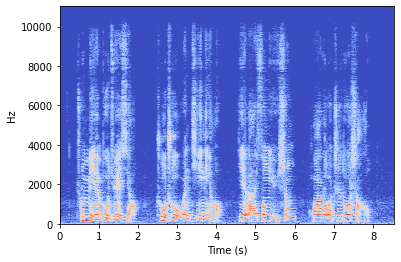

In [ ]:
f = rosa.stft(x)
rosa.display.specshow(rosa.power_to_db(np.abs(f)**2), sr=sr, y_axis='hz', x_axis='s')

**火车隧道**

https://www.openair.hosted.york.ac.uk/?page_id=525

In [ ]:
h1, sr = rosa.load('/content/drive/MyDrive/openair/innocent-railway-tunnel/middle_tunnel_1way_mono.flac')

Audio(h1, rate=sr) # normalize=False 

In [ ]:
y1 = signal.oaconvolve(x, h1, mode='full')
print(len(y1)/sr)
Audio(y1, rate=sr) # normalize=False

13.521768707482993


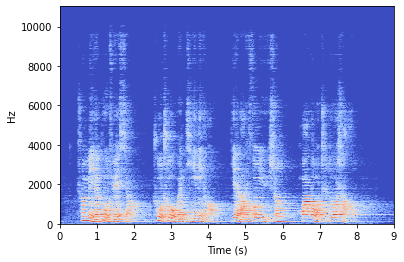

In [ ]:
f1 = rosa.stft(y1[0:sr*9])
rosa.display.specshow(rosa.amplitude_to_db(np.abs(f1)), sr=sr, y_axis='hz', x_axis='s')

**英国 York 大学 Central Hall**

https://www.openair.hosted.york.ac.uk/?page_id=435

In [ ]:
h2, sr = rosa.load('/content/drive/MyDrive/openair/central-hall-university-york/ir_row_1l_sl_centre_ch2.flac')
Audio(h2, rate=sr) # normalize=False 

In [ ]:
y2 = signal.convolve(x, h2)
print(len(y2)/sr)
Audio(y1, rate=sr) # normalize=False

11.021360544217687


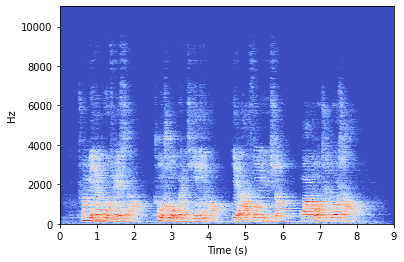

In [ ]:
f2 = rosa.stft(y2[0:sr*9])
rosa.display.specshow(rosa.amplitude_to_db(np.abs(f2)), sr=sr, y_axis='hz', x_axis='s')

**Deconvolution**

https://en.wikipedia.org/wiki/Deconvolution

One of Prof. Alan V. Oppenheim's faviourite examples: Digital restoration of Enrico Caruso's recordings by Thomas Stockham. 1975 paper: "Blind deconvolution through Digital Signal Processing".

* [MIT RES.6-007 Signals ans Systems, 1987](https://youtu.be/KJnAy6hzetw?t=760)
* [MIT RES.6-008 Digital Signal Processing, 1975](https://youtu.be/rkvEM5Y3N60?t=338)
* [MITx 6.341x Discrete-Time Signal Processing, 2016](https://learning.edx.org/course/course-v1:MITx+6.341x_2+2T2016/block-v1:MITx+6.341x_2+2T2016+type@sequential+block@Enrichment_lecture_How_Caruso_Lost_His_Orchestra/block-v1:MITx+6.341x_2+2T2016+type@vertical+block@Enrichment_Lecture_2_Video_3)



## FIR using Remez

$H(\omega) = H(z)|_{z=e^{j\omega}}$, $0 \le \omega \le \pi$

$H(z) =  \frac{b_0 + b_1z^{-1}+b_2z^{-2}+\cdots+b_Nz^{-N}}{1+a_1z^{-1}+a_2z^{-2}+\cdots+a_Mz^{-M}}$

For FIR, $a_i = 0,\ i > 0$

$H(z) = b_0 + b_1z^{-1}+b_2z^{-2}+\cdots+b_Nz^{-N}$

$H(w) = H(z)|_{z=e^{jw}} = b_0 + b_1e^{-1jw}+b_2e^{-2jw}+\cdots+b_Ne^{-jNw}$

$H(w) = \sum_{k=0}^N b_k e^{-jkw}$, this is DTFT.

Choose $b_k$ to minimize difference between $H(w)$ and the desired frequency response. 

Parks-McClellan algorithm 1973.

https://eeweb.engineering.nyu.edu/iselesni/EL713/remez/remez.pdf

In [ ]:
x, sr = rosa.load(rosa.example('brahms'))
print("Sample rate: %d, original length %.2f sec" % (sr, len(x) / sr))

x = x[0:int(sr*13.6)]
Audio(x, rate=sr) # normalize=False 

Sample rate: 22050, original length 45.84 sec


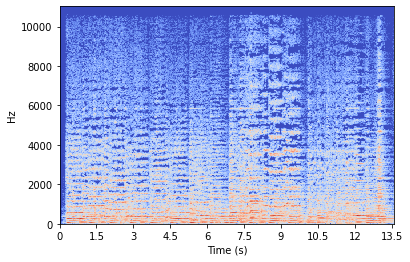

In [ ]:
f1 = rosa.stft(x)
rosa.display.specshow(rosa.amplitude_to_db(np.abs(f1)), sr=sr, y_axis='hz', x_axis='s')

固定电话的带宽是 200 Hz ~ 3.4 kHz，这里用低通模拟。

三个相互制约的因素：
* tap 数
* 阻带衰减 (dB)
* 过渡带宽度 (Hz)

Text(0.5, 0, 'Hz')

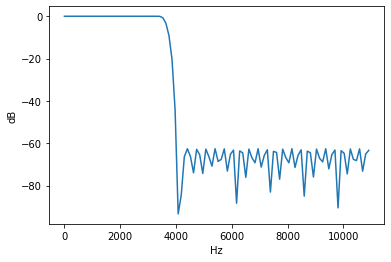

In [ ]:
numtaps = 128
h = signal.remez(numtaps, bands=[0, 3400, 4000, 0.5*sr], desired=[1, 0], fs=sr)

dlti = signal.dlti(h, [1])
w, mag, phase = dlti.bode()
plt.plot(w/(2*np.pi)*sr, mag)
plt.ylabel('dB'); plt.xlabel('Hz')
# plt.figure(2)
# plt.plot(w/np.pi, phase)

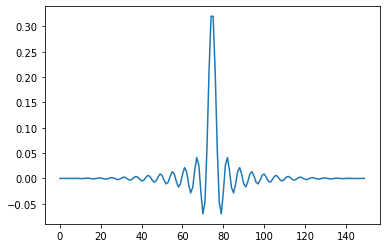

In [ ]:
plt.plot(h)

In [ ]:
# Filter
y = signal.oaconvolve(x, h, mode='full')  # 'full', 'valid', 'same'
print('%.3f' % (len(y)/sr))
Audio(y, rate=sr) # normalize=False

13.606


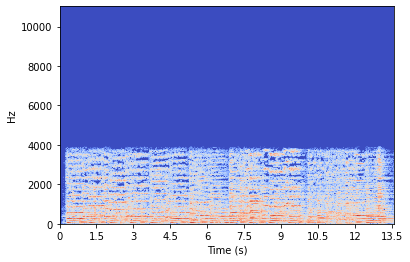

In [ ]:
f2 = rosa.stft(y)
rosa.display.specshow(rosa.power_to_db(np.abs(f2)**2), sr=sr, y_axis='hz', x_axis='s')

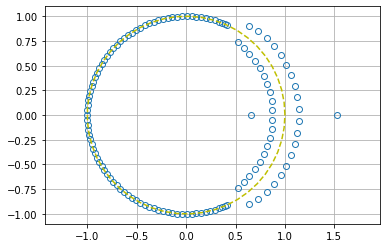

In [ ]:
draw_pzmap(dlti)

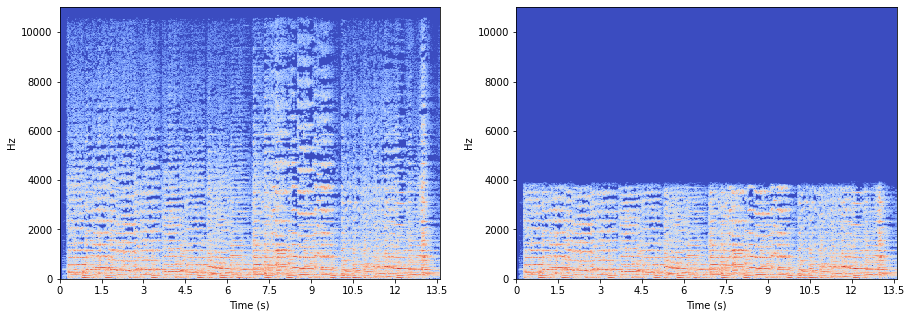

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
rosa.display.specshow(rosa.power_to_db(np.abs(f1)**2), sr=sr, y_axis='hz', x_axis='s')
plt.subplot(122)
rosa.display.specshow(rosa.power_to_db(np.abs(f2)**2), sr=sr, y_axis='hz', x_axis='s')

可见 4kHz 以上的高频被滤得干干净净。

当然，这只是原理验证，离实时的定点 DSP 实现还有相当的距离。

## DC blocker

Julius O. Smith, Introduction to Digital Filters with Audio Applications, http://ccrma.stanford.edu/~jos/filters/

Appendix B.3 https://ccrma.stanford.edu/~jos/filters/DC_Blocker.html

$y[n] = x[n]-x[n-1]+Ry[n-1]$

$H(z)=\dfrac{1-z^{-1}}{1-Rz^{-1}}$

It's a differentiator with exponential moving average.

Zeros: [1.]
Poles: [0.9]


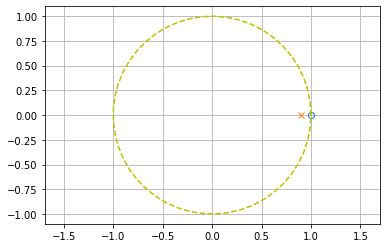

In [ ]:
R = 0.9
b = [1, -1]
a = [1, -R]
dlti = signal.dlti(b, a)
zeros = dlti.zeros
print('Zeros:', zeros)
print('Poles:', dlti.poles)
draw_pzmap(dlti)

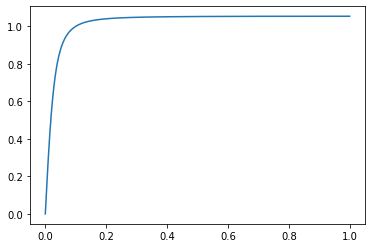

In [ ]:
w, mag = dlti.freqresp()
plt.plot(w/np.pi, np.abs(mag))

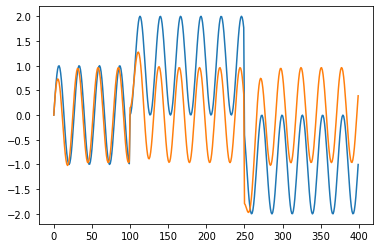

In [ ]:
t = np.linspace(0, 1, 400) * 2 *np.pi * 15
x = np.sin(t)
dc = np.concatenate([np.zeros(100), np.ones(150), -1 * np.ones(150)])
x = dc + x

y = signal.lfilter(b, a, x)
plt.plot(x)
plt.plot(y)

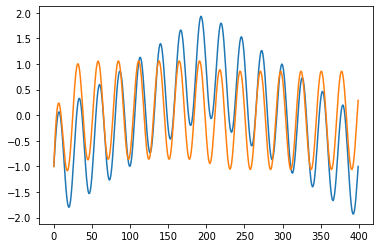

In [ ]:
t = np.linspace(0, 1, 400) * 2 *np.pi
x = np.sin(t * 15)
triangle = signal.sawtooth(t, 0.5)
x = x + triangle

y = signal.lfilter(b, a, x)
plt.plot(x)
plt.plot(y)

In [ ]:
@interact(R=(0, 1, 0.01))
def blocker(R=0.5):
  b = [1, -1]
  a = [1, -R]
  dlti = signal.dlti(b, a)
  plt.figure(figsize=(15,5))
  plt.subplot(121)
  draw_pzmap(dlti)
  w, mag = dlti.freqresp()
  plt.subplot(122)
  plt.plot(w/np.pi, np.abs(mag))

interactive(children=(FloatSlider(value=0.5, description='R', max=1.0, step=0.01), Output()), _dom_classes=('w…

## IIR Notch
https://www.mathworks.com/help/signal/ug/remove-the-60-hz-hum-from-a-signal.html

Sophocles J. Orfanidis. _Introduction to Signal Processing, 1996._ 

§11.3 Second-Order Peaking and Notching Filters

https://www.ece.rutgers.edu/~orfanidi/intro2sp/



In [ ]:
fs=1000
b, a = signal.iirnotch(60, Q=30, fs=fs)
d = signal.dlti(b, a)
print('b=', np.round(b, 5))
print('a=', np.round(a, 5))

b= [ 0.99376 -1.84794  0.99376]
a= [ 1.      -1.84794  0.98751]


$y[n] = 0.99376\,x[n] - 1.84794\,x[n-1] + 0.99376\,x[n-2] + 1.84794\,y[n-1] - 0.98751\,y[n-2]$

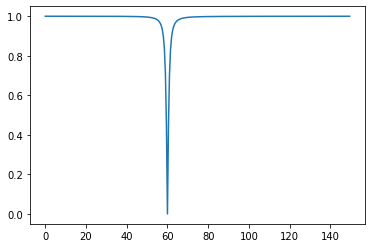

In [ ]:
w, amp = d.freqresp(n=1000)
w=w[0:300]
amp=amp[0:300]
plt.plot(w/(2*np.pi)*fs, np.abs(amp))

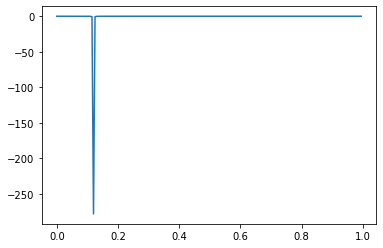

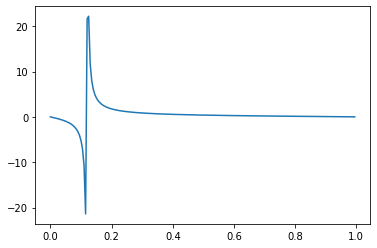

In [ ]:
w, mag, phase = d.bode(n=200)
plt.plot(w/np.pi, mag)
plt.figure()
plt.plot(w/np.pi, phase)

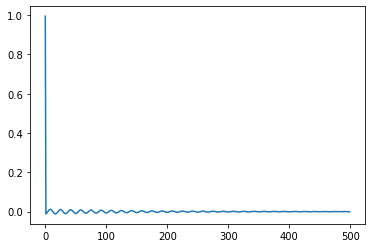

In [ ]:
t, y = d.impulse(n=500)
plt.plot(t, y[0])

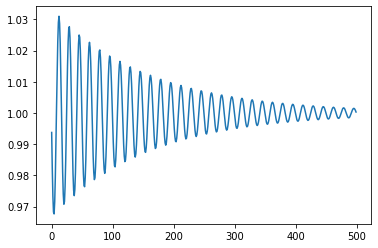

In [ ]:
t, y = d.step(n=500)
plt.plot(t, y[0])

zeros 1.00000 60.000Hz
poles 0.99374 59.992Hz


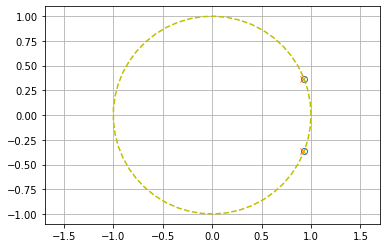

In [ ]:
print('zeros %.5f %.3fHz' % (np.abs(d.zeros[0]), np.angle(d.zeros[0]) * fs / (2*np.pi)))
print('poles %.5f %.3fHz' % (np.abs(d.poles[0]), np.angle(d.poles[0]) * fs / (2*np.pi)))
draw_pzmap(d)

**EEG**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


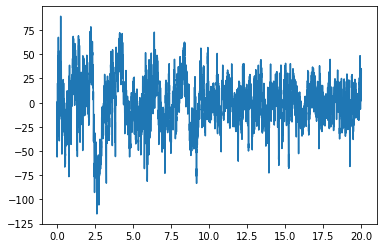

In [ ]:
eeg = np.loadtxt('/content/drive/MyDrive/openair/eeg_data.txt').T
fs = 500
x = eeg[0]
t = np.arange(len(x)) / fs
plt.plot(t, x)

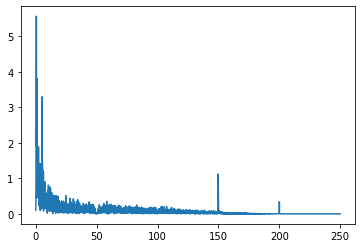

In [ ]:
fft = np.fft.rfft(x) / len(x)
freq = np.arange(len(fft)) / len(fft) * fs / 2
plt.plot(freq, np.abs(fft))

(0.0, 0.5)

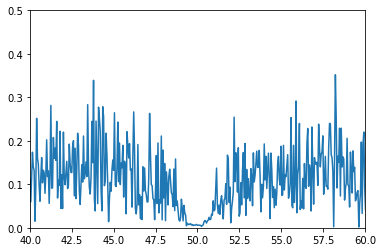

In [ ]:
plt.plot(freq, np.abs(fft))
plt.xlim(40, 60)
plt.ylim(0, 0.5)

(140.0, 160.0)

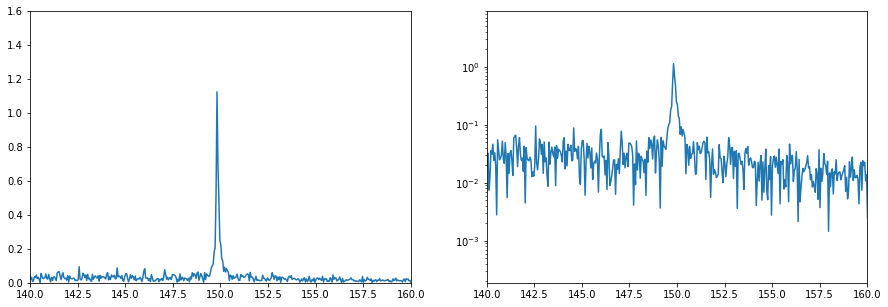

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(freq, np.abs(fft))
plt.xlim(140, 160)
plt.ylim(0, 1.6)
plt.subplot(122)
plt.semilogy(freq, np.abs(fft))
plt.xlim(140, 160)

In [ ]:
b, a = signal.iirnotch(150, Q=50, fs=fs)
d = signal.dlti(b, a)
print('b=', np.round(b, 5))
print('a=', np.round(a, 5))

b= [0.9815 0.6066 0.9815]
a= [1.      0.6066  0.96299]


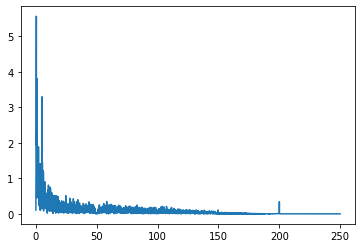

In [ ]:
y = signal.lfilter(b, a, x)
ffty = np.fft.rfft(y) / len(y)
freq = np.arange(len(ffty)) / len(ffty) * fs / 2
plt.plot(freq, np.abs(ffty))

(140.0, 160.0)

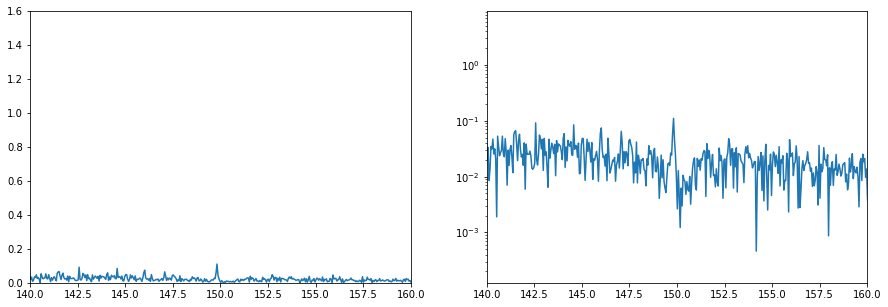

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(freq, np.abs(ffty))
plt.xlim(140, 160)
plt.ylim(0, 1.6)
plt.subplot(122)
plt.semilogy(freq, np.abs(ffty))
plt.xlim(140, 160)

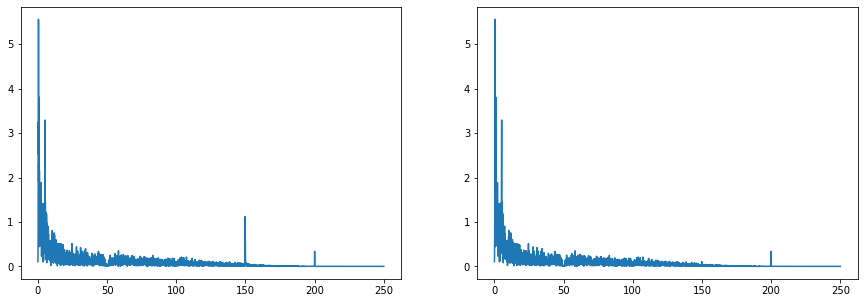

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(freq, np.abs(fft))
plt.subplot(122)
plt.plot(freq, np.abs(ffty))

(140.0, 160.0)

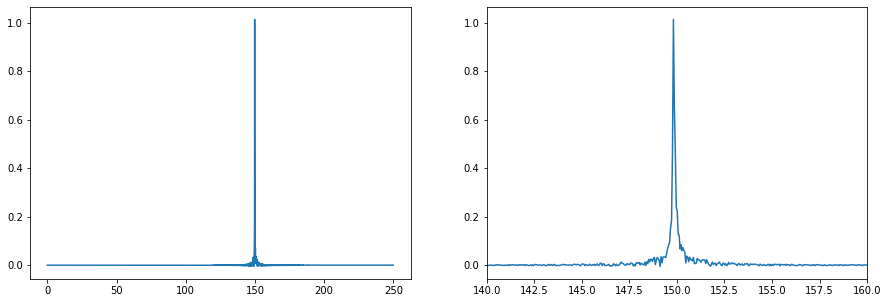

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(freq, np.abs(fft)-np.abs(ffty))
plt.subplot(122)
plt.plot(freq, np.abs(fft)-np.abs(ffty))
plt.xlim(140, 160)

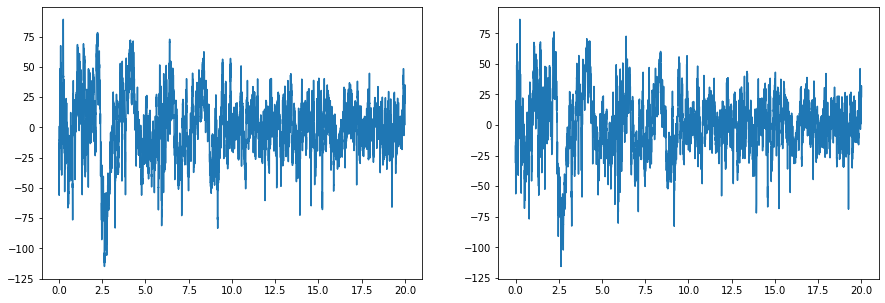

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(t, x)
plt.subplot(122)
plt.plot(t, y)

(1.0, 1.1)

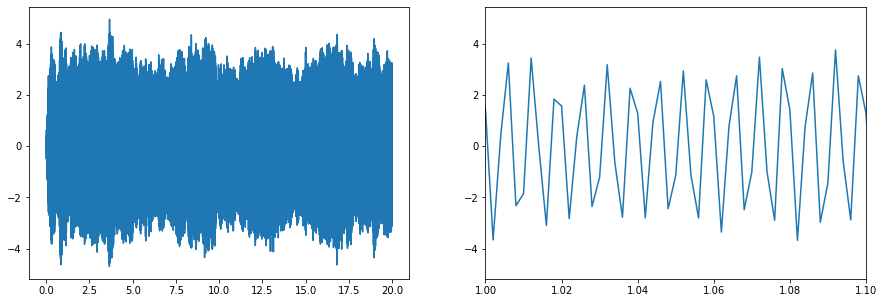

In [ ]:
diff = y-x
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(t, diff)
plt.subplot(122)
plt.plot(t, diff)
plt.xlim(1, 1.1)

(140.0, 160.0)

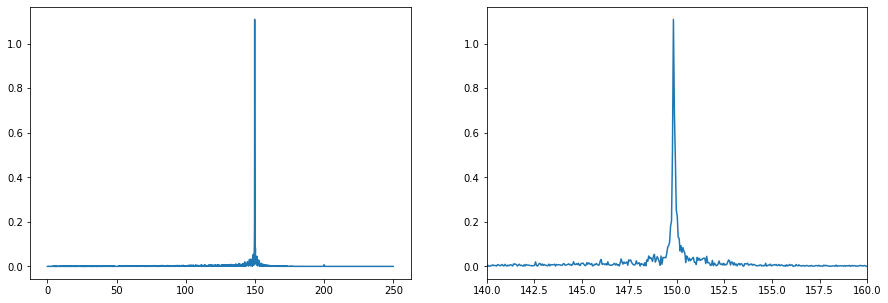

In [ ]:
fftd = np.fft.rfft(diff) / len(diff)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(freq, np.abs(fftd))
plt.subplot(122)
plt.plot(freq, np.abs(fftd))
plt.xlim(140, 160)

FFT(y - x) = FFT(y) - FFT(x)

In [ ]:
# plt.plot(freq, np.abs(ffty-fft-fftd))

# Lab3: Frequency Analysis --- DTMF

### 信号的合成（synthesis）与分解（analysis）

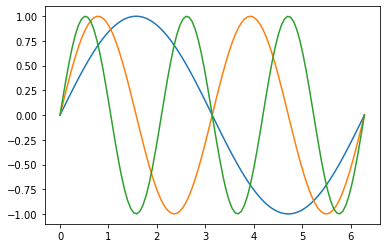

In [ ]:
w = np.linspace(0, 2*np.pi, 100)
x = np.sin(w)
x2 = np.sin(2*w)
x3 = np.sin(3*w)
p=plt.plot(w, x, w, x2, w, x3)

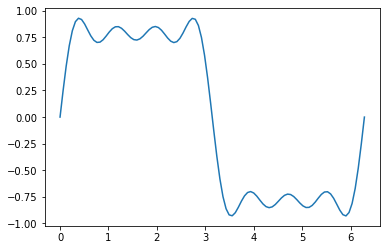

In [ ]:
x5 = np.sin(5*w)
x7 = np.sin(7*w)
plt.plot(w, x + x3 / 3 + x5 / 5 + x7 / 7)

基本问题：信号合成的求逆。例如对于采用率为 48kHz，合成一个 440Hz 的正弦信号：

$$x = \sin(2\pi f t), \quad \mathrm{where}\ f = 440\mathrm{Hz}$$

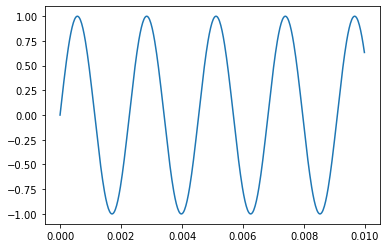

In [ ]:
fs = 48000
t = np.arange(fs * 10 / 1000) / fs  # 10ms
f = 440  # https://en.wikipedia.org/wiki/A440_(pitch_standard)
x0 = np.sin(2*np.pi*f*t)
plt.plot(t, x0)

3.325019045526767e-13


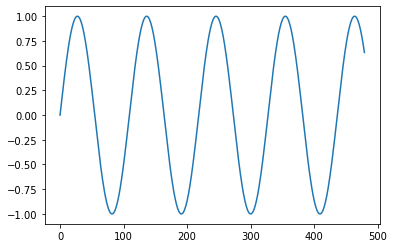

In [ ]:
x1 = rosa.tone(440, sr=48000, duration=3)
plt.plot(x1[0:480])
print(sum(np.abs(x0-x1[0:480])))
Audio(data=x1, rate=48000)

如果拿到的是这个输入信号，如何求出它的频率、幅度、相位？

对于单一频率的信号，可以测量其周期（过零点），那么多频率的信号呢？

如果一个 1000Hz 的正弦波和一个 440Hz 的正弦波叠加在一起，得到信号 $y = \sin(1000 \omega) + \sin(440 \omega)$ . 如何找到这两个频率？

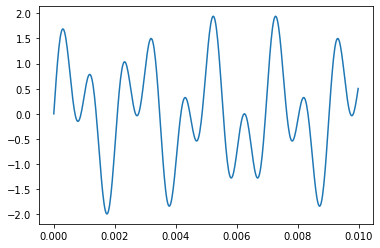

In [ ]:
x2 = rosa.tone(1000, sr=48000, duration=3)
y = x1 + x2
plt.plot(t, y[0:480])
Audio(data=y, rate=48000)

如果已知某信号包含高低两个频率，如何去掉其中任何一个？ Filtering

### DTMF

https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling

|        | 1209 Hz | 1336 Hz | 1477 Hz |
| -----: | :-----: | :-----: | :-----: |
| 697 Hz |  **1**  |  **2**  |  **3**  |
| 770 Hz |  **4**  |  **5**  |  **6**  |
| 852 Hz |  **7**  |  **8**  |  **9**  |
| 941 Hz |  **$*$** |  **0**  |  **#**  |

https://www.mathworks.com/help/signal/ug/dft-estimation-with-the-goertzel-algorithm.html

https://hackaday.com/2020/11/13/dsp-spreadsheet-the-goertzel-algorithm-is-fouriers-simpler-cousin/


2012 年 8 月”南京大学学生听拨号声破解周鸿祎手机号“

In [ ]:
import itertools

dtmf_row = [697, 770, 852, 941]
dtmf_col = [1209, 1336, 1477]
dtmf_digits = '123456789*0#'
digit_to_freq = dict(zip(dtmf_digits, itertools.product(dtmf_row, dtmf_col)))
digit_to_freq

{'#': (941, 1477),
 '*': (941, 1209),
 '0': (941, 1336),
 '1': (697, 1209),
 '2': (697, 1336),
 '3': (697, 1477),
 '4': (770, 1209),
 '5': (770, 1336),
 '6': (770, 1477),
 '7': (852, 1209),
 '8': (852, 1336),
 '9': (852, 1477)}

### Generate DTMF tone

In [8]:
digit_to_freq = {
    '1' : (697, 1209),
    '2' : (697, 1336),
    '3' : (697, 1477),
    '4' : (770, 1209),
    '5' : (770, 1336),
    '6' : (770, 1477),
    '7' : (852, 1209),
    '8' : (852, 1336),
    '9' : (852, 1477),
    '*' : (941, 1209),
    '0' : (941, 1336),
    '#' : (941, 1477),
}

fs = 8000
def dtmf_single(digit):
  on = 800   # 100ms
  x = np.zeros(on)
  w = np.arange(on) / fs * 2 * np.pi
  freqs = digit_to_freq[digit]
  for f in freqs:
    x += np.sin(w * f) * 0.5
  return x

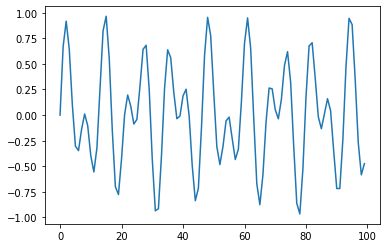

In [ ]:
digit_1 = dtmf_single('1')
plt.plot(digit_1[0:100])
Audio(digit_1, rate=fs)

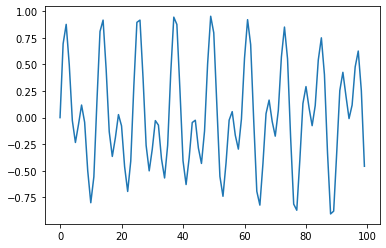

In [ ]:
digit_2 = dtmf_single('2')
plt.plot(digit_2[0:100])
Audio(digit_2, rate=fs)

In [ ]:
def dtmf_multi(digits):
  off = 800  # 100ms
  gap = np.zeros(off)
  y = np.array([])
  for d in digits:
    if d != '-':
      x = dtmf_single(d)
    else:
      x = np.zeros(200)
    y = np.append(y, x)
    y = np.append(y, gap)
  return y

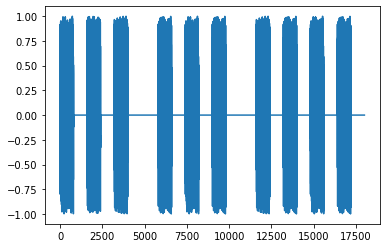

In [ ]:
dial_e = dtmf_multi('271-828-1828')
plt.plot(dial_e)
Audio(dial_e, rate=fs)

In [ ]:
dial_today = dtmf_multi('2022-08-05')
Audio(dial_today, rate=fs)

### Single point DFT

一个 Naive 的频率分析方法：用已知频率的正弦信号去点乘输入信号（计算相关度），如果得到的数越大，说明输入信号在这个频率的分量越大。这正是 DFT/FFT 的原理（之一）。

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j 2 \pi  n k / N}$$

In [6]:
def single_dft(x, k):
  N = len(x)
  n = np.arange(N) / N  #  n in 0, 1, ..., N-1
  w = np.exp(-2j * np.pi * n * k)
  return np.dot(x, w)
  # Horner's rule to save space, if necessary

### Find $N$ and $k$

For Fs = 8000

* N = 205 in "Add DTMF generation and decoding to DSP-μP designs", Pat Mock, 1989.
https://www.ti.com/litv/pdf/spra168

* N = 105 in "Modified Goertzel Algorithm in DTMF Detection Using the TMS320C80", Chiouguey J. Chen, 1996. TI SPRA066

* N = 136 in "DTMF Tone Generation and Detection: An Implementation Using the TMS320C54x", Gunter Schmer, 2000. TI SPRA096A.


In [3]:
freqs = np.array([697, 770, 852, 941, 1209, 1336, 1477])
np.diff(freqs)

array([ 73,  82,  89, 268, 127, 141])

In [ ]:
np.round(freqs * 21 / 19, 1)

array([ 770.4,  851.1,  941.7, 1040.1, 1336.3, 1476.6, 1632.5])

https://engineering.stackexchange.com/questions/37693/how-were-the-tones-for-dtmf-chosen
> The tones have been carefully selected to minimize harmonic interference and the probability that a pair of high and low tones will be simulated by the human voice, thus protecting network control signaling.

In [ ]:
freqs * 2

array([1394, 1540, 1704, 1882, 2418, 2672, 2954])

In [ ]:
np.array([freqs]).T

In [4]:
@interact(nfft = (60, 250, 5))
def how_many_bins(nfft=205):
  fs = 8000
  t = np.arange(nfft)/fs
  x = np.sin(2*np.pi* freqs.reshape(len(freqs), 1) * t)
  print('bin = %.2f Hz' % (fs / nfft))
  for i in x:
    fft = np.fft.rfft(i)
    plt.plot(np.abs(fft[0:(nfft//4)])/nfft)

interactive(children=(IntSlider(value=205, description='nfft', max=250, min=60, step=5), Output()), _dom_class…

Find k's

In [ ]:
N = 205
bin = fs / N
print(freqs / bin)
np.round(freqs / bin, 0)

[17.860625 19.73125  21.8325   24.113125 30.980625 34.235    37.848125]


array([18., 20., 22., 24., 31., 34., 38.])

In [ ]:
N = 205
sr = 8000
print('%.2f Hz' % (sr / N))

k = np.array([18, 20, 22, 24, 31, 34, 38])
print(np.round(k * sr / N, 2))
print(np.round(k * sr / N - freqs, 2))

39.02 Hz
[ 702.44  780.49  858.54  936.59 1209.76 1326.83 1482.93]
[ 5.44 10.49  6.54 -4.41  0.76 -9.17  5.93]


In [ ]:
N = 205
x = dtmf_single('7')[0:N]

k = 31
fft = np.fft.rfft(x)
print('fft:', fft[k])

dft = single_dft(x, k)
print('dft:', dft, np.abs(dft))
print('diff:', np.abs(dft - fft[k]))

fft: (-3.2533465551031764-52.00556579704333j)
dft: (-3.253346555103054-52.00556579704328j) 52.10722730752615
diff: 1.3227597997294158e-13


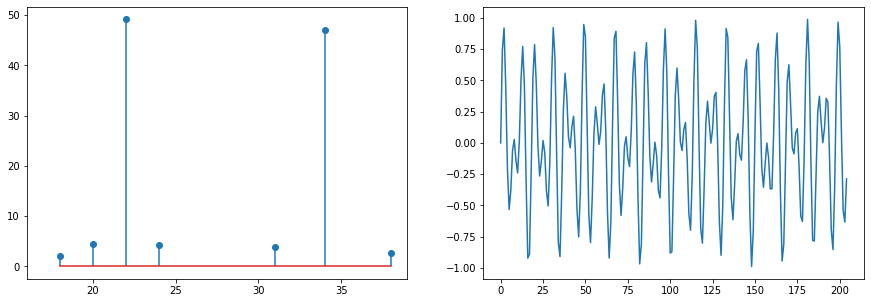

In [ ]:
N = 205
x = dtmf_single('8')[0:N]

bins = [18, 20, 22, 24, 31, 34, 38]
y = np.zeros(len(bins))

for i, k in enumerate(bins):
  y[i] = np.abs(single_dft(x, k))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.stem(bins, y, use_line_collection=True)
plt.xlim(16, 39)
plt.subplot(122)
plt.plot(x)

In [9]:
@interact(digit=(0, 9, 1))
def dtmf(digit=1):
  N = 205
  x = dtmf_single(str(digit))[0:N]

  bins = [18, 20, 22, 24, 31, 34, 38]
  y = np.zeros(len(bins))

  for i, k in enumerate(bins):
    y[i] = np.abs(single_dft(x, k))
  plt.figure(figsize=(15,5))
  plt.subplot(121)
  plt.stem(bins, y, use_line_collection=True)
  plt.xlim(15, 40)
  plt.ylim(-5, 60)
  plt.subplot(122)
  plt.plot(x[0:100])

interactive(children=(IntSlider(value=1, description='digit', max=9), Output()), _dom_classes=('widget-interac…

Threshold = 30

In [ ]:
N = 205
x = np.zeros(N)
x[0] = 1
bins = [18, 20, 22, 24, 31, 34, 38]
for k in bins:
  print(np.abs(single_dft(x, k)))

1.0
1.0
1.0
1.0
1.0
1.0
1.0


### Goertzel algorithm

格尔泽 1958, earlier than FFT.

https://en.wikipedia.org/wiki/Goertzel_algorithm

A Simpler Goertzel Algorithm, Rick Lyons, 2021.
https://www.dsprelated.com/showarticle/1386.php

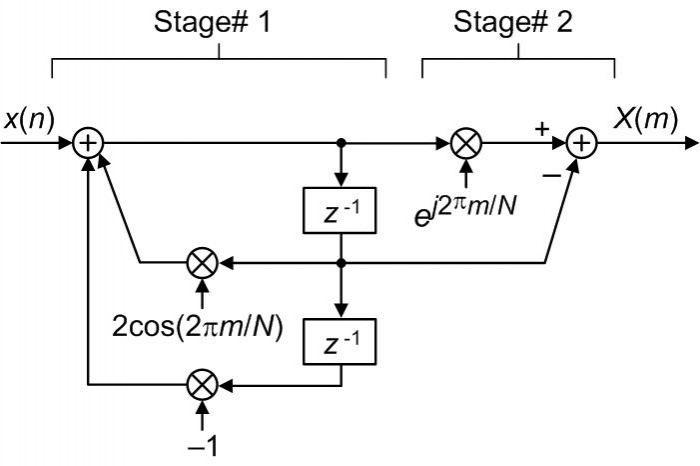

https://www.mathworks.com/help/signal/ug/dft-estimation-with-the-goertzel-algorithm.html

$\omega = \dfrac{2\pi k} {N}$

Loop through x[n]: $s[n]=x[n]+2\cos(\omega)s[n-1]-s[n-2]$

At the end, $X(\omega) =  e^{j\omega}s[N-1] -s[N-2]$

$power = (s[N-1])^2 + (s[N-2])^2 - 2 \cos(\omega)s[N-1]s[N-2]$

* one coefficient: $2\cos \omega$
* real number arithmetic
  * $N$ multiplications and $2N$ additions for $s[N]$
* constant space (2 real numbers for $s[n-1]$ and $s[n-2]$)

In [ ]:
k = 18
N = 205
x = dtmf_single('1')[0:N]

w = k * 2 * np.pi / N
c = np.cos(w)
c2 = 2 * c
s1 = 0
s2 = 0

for p in x:
  s0 = p + c2 * s1 - s2
  s2 = s1
  s1 = s0

goert = np.exp(1j*w) * s1 - s2

dft = single_dft(x, k)
print(dft) 
print(goert)
print(np.real_if_close(dft-goert))

power = s1 * s1 + s2 * s2 - c2 * s1 * s2

print(np.abs(dft) ** 2)
print(np.abs(goert) ** 2)
print(power)

(-20.74101651888851-45.04381314418047j)
(-20.741016518888266-45.04381314418047j)
-2.4513724383723456e-13
2459.1348688046514
2459.1348688046405
2459.134868804641


In [10]:
def goertzel(x, k):
  N = len(x)
  s2 = 0
  s1 = 0
  s0 = 0
  w = k * 2 * np.pi / N
  c2 = 2 * np.cos(w)
  for p in x:
    s0 = p + c2 * s1 - s2
    s2 = s1
    s1 = s0
  power = s1 * s1 + s2 * s2 - c2 * s1 * s2
  return power

In [ ]:
N = 205
bins = [18, 20, 22, 24, 31, 34, 38]

results = np.zeros((10, len(bins)))

for digit in '0123456789':
  x = dtmf_single(digit)[0:N]
  fft = np.fft.rfft(x)
  for i, k in enumerate(bins):
    g = goertzel(x, k)
    assert np.allclose(g, np.abs(fft[k])**2)
    results[int(digit), i] = g
print(np.round(results, 0))

[[   2.    3.   10. 2589.    5. 2104.   13.]
 [2459.   10.    3.    1. 2683.    1.    0.]
 [2487.   13.    5.    3.   14. 2203.    8.]
 [2428.    8.    2.    1.    1.    3. 2457.]
 [  54. 2032.   26.    6. 2713.    1.    0.]
 [  53. 2042.   28.    9.   14. 2198.    8.]
 [  60. 1994.   21.    4.    0.    2. 2479.]
 [   5.   21. 2380.   13. 2715.    1.    0.]
 [   5.   19. 2415.   18.   15. 2209.    7.]
 [   7.   25. 2340.   10.    0.    2. 2471.]]


power threshold = 1000

### Detect single digit

In [ ]:
bin_to_digit = {}
N = 205
fs = 8000

for digit, freqs in digit_to_freq.items():
  bins = np.round(np.array(freqs) / (fs / N), 0)
  key = (int(bins[0]), int(bins[1]))
  bin_to_digit[key] = digit
print(bin_to_digit)

# return '0' ~ '9' if detected, - if not
def detect_single(x):
  N = 205
  if len(x) < N:
    x = np.append(x, np.zeros(N - len(x)))
  x = x[0:N]
  assert len(x) == N

  bins = [18, 20, 22, 24, 31, 34, 38]
  found = []
  for k in bins:
    g = goertzel(x, k)
    if g > 1000:
      found.append(k)
  return bin_to_digit.get(tuple(found), '-')

{(18, 31): '1', (18, 34): '2', (18, 38): '3', (20, 31): '4', (20, 34): '5', (20, 38): '6', (22, 31): '7', (22, 34): '8', (22, 38): '9', (24, 31): '*', (24, 34): '0', (24, 38): '#'}


In [ ]:
for digit in '0123456789':
  print(digit, detect_single(dtmf_single(digit)))

print(detect_single(np.zeros(0)))
print(detect_single(np.zeros(100)))
print(detect_single(np.zeros(500)))
print(detect_single(np.ones(1000)))
print(detect_single(dtmf_single('1') + dtmf_single('2')))
print(detect_single(dtmf_single('1') + dtmf_single('5')))
print(detect_single(dtmf_single('1')*0.5 + dtmf_single('6')))

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
-
-
-
-
-
-
6


### Put it together

In [ ]:
def dtmf_decode(x):
  result = ''
  i = 0
  N = 205

  last_digit = '-'
  last_count = 0
  while i < len(x):
    digit = detect_single(x[i:i+N])
    i += N
    if digit == last_digit:
      last_count += 1
      continue
    if digit == '-':
      if last_count >= 2:
        result += last_digit
    last_digit = digit
    last_count = 1
  return result
    

In [ ]:
print(dtmf_decode(dtmf_multi('123-456-7890')))

1234567890


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Online DTMF Tone Generator: 
https://www.audiocheck.net/audiocheck_dtmf.php

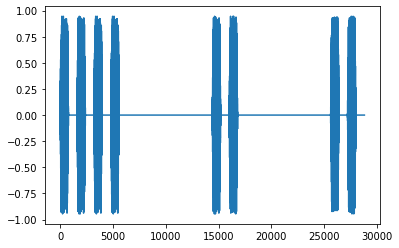

In [ ]:
x, sr = rosa.load('/content/drive/MyDrive/openair/dtmf_2022_07_31.wav', sr=None)
assert sr == 8000
plt.plot(x)
Audio(x, rate=sr) # normalize=False

In [ ]:
print(dtmf_decode(x))

20220731


https://en.wikipedia.org/wiki/File:DTMF_dialing.ogg

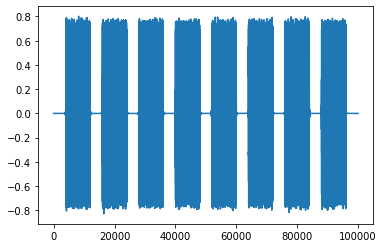

In [ ]:
x, sr = rosa.load('/content/drive/MyDrive/openair/DTMF_dialing.ogg', sr=None)
assert sr == 8000
plt.plot(x)
Audio(x, rate=sr) # normalize=False

In [ ]:
y = dtmf_decode(x)
print(len(y), y)

75 069667535641518023367314163083381604400826146625368963884821381785073643399


In [ ]:
print(len('06966753564646415180233673141636083381604400826146625368963884821381785073643399'))

80


https://www.sigidwiki.com/wiki/Dual_Tone_Multi_Frequency_(DTMF)

### Real world requirements

https://web.archive.org/web/20110925184759/http://nemesis.lonestar.org/reference/telecom/signaling/dtmf.html

* Accept frequency error < 1.5%
* Reject frequency error > 3.5%
* Duration 50ms/45ms
* Power 0 to -25 dBm, 
* Twist 

Some real world DTMF recievers also checks 2nd harmonics of DTMF frequencies.
So 16 points are calculated.

DTMF receiver chips:
* CM8870CSI (obsoleted) by California Micro Devices Corp. 215 Topaz Street, Milpitas, California  95035
* MT8870D from Zarlink (active)

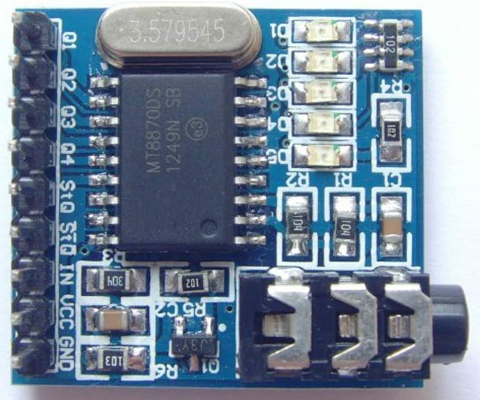


https://github.com/freeswitch/spandsp/blob/master/src/dtmf.c

### Summary

Goertzel Algorithm for a Non-integer Frequency Index, Rick Lyons, 2013.
https://www.dsprelated.com/showarticle/495.php

# Lab4: DFT and FFT

https://en.wikipedia.org/wiki/Discrete_Fourier_transform

DFT 定义：对于 $N$ 个点的输入信号 $x[n], n = 0, 1, \ldots, N-1$

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j 2 \pi  n k / N} \quad \mathrm{for}\ k = 0, 1, \ldots, N-1$$

$$X[k] = \sum_{n=0}^{N-1} x[n] w_N^{nk}  \quad \mathrm{where} \quad w_N = e^{-j 2 \pi / N} $$

1. 电子系教材的传统讲法：Fourier 系数 ⇒ Fourier 变换 ⇒ DTFT ⇒ DFT 
https://en.wikipedia.org/wiki/Fourier_series

|     | 周期 | 非周期 | 课程 | 数学工具 |
| --- | ---- | ---- | --- | --- |
| 连续 | Fourier 系数 |  Fourier 变换 | 《信号与系统》 | 积分 |
| 离散 | DFT | DTFT | 《数字信号处理》 | 求和（向量内积）|

这种讲法对于非 EE 专业的人来说，路径太长了。现在数字信号处理应用非常广泛，很多非 EE 专业的人也需要学习 DSP （非指 DSP 芯片），特别是可能用到 FFT 来提取频率特征，例如在 Web 页面上显示音乐的视觉特效。我认为对于这部分人，可以在学过线性代数的基础上，用矩阵乘法的概念直接讲 DFT/FFT，跳过前面的 DTFT 等铺垫，用一两个小时的时间掌握 FFT 的精髓。

DFT 叫离散 Fourier 变换，其实或许叫“离散 Fourier 级数”更合适，因为它得到的是一个数组，而不是连续函数。FFT 是计算 DFT 的快速算法，但是因为估计没有人会按 DFT 的定义去算，那样太慢了，于是 DFT 和 FFT 往往可以不加区分地使用。

2. 线性代数，矩阵乘以向量 $\Rightarrow$ 酉空间的坐标变换 https://www.youtube.com/watch?v=M0Sa8fLOajA
3. 信号的相关性，$X(\omega) = \langle \boldsymbol x, \boldsymbol s_\omega \rangle$ ，$ \boldsymbol s_\omega $ 是角频率 $\omega$ 的 complex sinusoid 信号
4. 《算法导论》独辟蹊径的讲法：多项式乘法（卷积）的快速算法 https://www.youtube.com/watch?v=h7apO7q16V0

叠加两个信号很容易，如何把它分解为原始信号？

In [11]:
@interact(amp=(0, 1, 0.1), phi=(-1,1,0.1))
def synthesis(amp = 1, phi=0):
  w = np.linspace(0, 4*np.pi, 100)
  x1 = np.sin(w)
  plt.plot(w, x1)
  x2 = np.sin(2*w + phi*np.pi) * amp
  plt.plot(w, x2)
  plt.plot(w, x1+x2)
  plt.ylim(-2,2)

interactive(children=(FloatSlider(value=1.0, description='amp', max=1.0), FloatSlider(value=0.0, description='…

### Spot Correlation

对于实数，$\boldsymbol a, \boldsymbol b$ 两个向量的内积 $\langle \boldsymbol a, \boldsymbol b\rangle = \boldsymbol a \cdot \boldsymbol b = \displaystyle \sum_ i a_i b_i$

$\boldsymbol a \cdot \boldsymbol b$ 表示 $\boldsymbol a$ 在 $\boldsymbol b$ 上的投影长度。如果 $\boldsymbol a, \boldsymbol b$ 同向或反向，内积最大，如果 $\boldsymbol a, \boldsymbol b$ 垂直（正交），内积为 0.

怎么知道信号 $\boldsymbol{x} = (x_0, x_1, \ldots, x_{N-1})$ 有哪些频率成分？

一个 naive 的想法：用一个已知频率为 $\omega=2\pi f / N$ 的信号 $\boldsymbol{s}_\omega = \cos(\omega n)$ 去试，乘出来的结果越大，说明信号 $\boldsymbol{x}$ 在这个频率上的分量越大，也就是 $\boldsymbol{x}$ 和 $\boldsymbol{s}_\omega$ 的“相关性”强。

但是，就算 $\boldsymbol{x}$ 的频率也是 $\omega$，
但不巧 $\boldsymbol x = \sin(\omega n)$ ，
结果 $ \boldsymbol x \cdot \boldsymbol{s}_\omega = 0$ 咋办？



In [12]:
@interact(phi=(-1,1,0.1))
def dot_prod(phi=0):
  w = np.linspace(0, 4*np.pi, 101)
  s = np.sin(w)
  plt.plot(w, s)
  x = np.sin(w - phi*np.pi)
  plt.plot(w, x)
  plt.plot(w, x * s)
  print('dot prod = %.3f' % sum(x*s))
  plt.ylim(-1.5, 1.5)

interactive(children=(FloatSlider(value=0.0, description='phi', max=1.0, min=-1.0), Output()), _dom_classes=('…

Complex sinusoid

$ s _ {\omega n} = e^{j\omega n} = \cos(\omega n) + j\sin(\omega n)$

$\boldsymbol s _ \omega$ 同时有 sin 和 cos，就不怕 $\boldsymbol x$ 的相位怎么变了，而且附带的好处是能同时求出幅度和相位。 

不过，$\boldsymbol s _ \omega$ 是复数，内积公式改为 $\langle \boldsymbol a, \boldsymbol b\rangle = \boldsymbol a \cdot \boldsymbol b = \displaystyle \sum_ i a_i \overline{b_i}$

$X(\omega) = \langle \boldsymbol x, \boldsymbol s _ \omega\rangle = \displaystyle \sum_n x_n \overline{s_{\omega n}} = \sum_n x_n e^{-j\omega n}$

In [13]:
@interact(degree=(-180,180,5))
def correlation(degree=0):
  w = np.arange(100) * 4 * np.pi / 100
  s = np.exp(1j * w)
  plt.plot(w, s.real)
  plt.plot(w, s.imag)
  x = np.cos(w + degree / 180 *np.pi)
  plt.plot(w, x)
  #plt.plot(w, x * s)
  y = np.vdot(s, x)
  print('dot prod amp = %.3f  angle = %.1f' % (np.abs(y), np.angle(y) / np.pi*180))
  plt.ylim(-1.5, 1.5)

interactive(children=(IntSlider(value=0, description='degree', max=180, min=-180, step=5), Output()), _dom_cla…

Understanding the Discrete Fourier Transform By R.N. Mutagi

> DFT equations, without insight into what the summations signify, often look formidable to many engineers. DFT can be interpreted in terms of **spot correlation** to understand the physical meaning of the transform.

In [14]:
@interact(s_freq=(300, 600, 10), x_degree=(0, 180, 5))
def find_peak(s_freq=500, x_degree=0):
  fs = 48000
  t = np.arange(500) / fs
  x_freq = 450
  x = np.sin(2*np.pi*x_freq*t + x_degree / 180 * np.pi)
  plt.plot(t, x)
  s = np.exp(2j*np.pi*s_freq*t)
  plt.plot(t, s.imag)
  y = np.vdot(s, x)
  print('amp = %.3f  angle = %.2f' % (np.abs(y), np.angle(y) / np.pi * 180))

interactive(children=(IntSlider(value=500, description='s_freq', max=600, min=300, step=10), IntSlider(value=0…

In [15]:
@interact(x_freq=(300, 600, 10), degree=(0, 180, 5))
def find_peak(x_freq=500, degree=0):
  fs = 48000
  t = np.arange(500) / fs
  x = np.cos(2*np.pi*x_freq*t + degree / 180 * np.pi)

  freq_range = np.arange(200, 700)
  w = np.array([freq_range]).T @ np.array([t])
  s = np.exp(2j*np.pi*w)
  plt.plot(freq_range, np.abs(s @ x))
  plt.ylim(-5, 270)
  
  hamming = signal.windows.hamming(len(x))
  y = hamming * x
  plt.plot(freq_range, np.abs(s @ y))

interactive(children=(IntSlider(value=500, description='x_freq', max=600, min=300, step=10), IntSlider(value=0…

### DFT Matrix

https://en.wikipedia.org/wiki/DFT_matrix


行向量乘以矩阵 $\Rightarrow$ 行向量（矩阵的行的线性组合）

矩阵乘以列向量 $\Rightarrow$ 列向量（矩阵的列的线性组合）

$A\boldsymbol x=\boldsymbol b$

$$A\boldsymbol x =
[\boldsymbol a_1\ \boldsymbol a_2\ \cdots\ \boldsymbol a_n]
\begin{bmatrix}
           x_{1} \cr
           x_{2} \cr
           \vdots \cr
           x_{n}
         \end{bmatrix}=x_1\boldsymbol a_1 + x_2\boldsymbol a_2+\cdots+x_n\boldsymbol a_n=\begin{bmatrix}
           b_{1} \cr
           b_{2} \cr
           \vdots \cr
           b_{n}
         \end{bmatrix}$$

In [ ]:
import scipy.linalg as linalg

In [ ]:
A = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
              [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
              [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
              [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
              [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],])
b = [1, 2, 3, 2, 1, -1, -2, -3, -2, -1]
x = linalg.solve(A, b)  # O(N^3)
print(x)
print(A @ x)
assert np.allclose(A @ x, b)

[-1. -1.  1.  1.  2.  1.  1. -1. -1. -1.]
[ 1.  2.  3.  2.  1. -1. -2. -3. -2. -1.]


In [ ]:
Ainv = linalg.inv(A)  # O(N^3)
print(Ainv)
x2 = Ainv @ b  # O(N^2)
print('x2 =', x2)

[[ 1. -1.  0. -0.  0. -0.  0. -0.  0. -0.]
 [ 0.  1. -1. -0.  0. -0.  0. -0.  0. -0.]
 [ 0.  0.  1. -1.  0. -0.  0. -0.  0. -0.]
 [ 0.  0.  0.  1. -1. -0.  0. -0.  0. -0.]
 [ 0.  0.  0.  0.  1. -1.  0. -0.  0. -0.]
 [ 0.  0.  0.  0.  0.  1. -1. -0.  0. -0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
x2 = [-1. -1.  1.  1.  2.  1.  1. -1. -1. -1.]


$y[n] = x[n] - x[n+1]$

Sinusoid

\begin{aligned}
S \boldsymbol f &= \boldsymbol x \\
S^{-1} \boldsymbol x &= \boldsymbol f
\end{aligned}

$$S = \left[
\begin{array}{cccc}
| & | & & | \\
\boldsymbol s_0 & \boldsymbol s_1 & \cdots &\boldsymbol s_{N-1} \\
| & | & & |
\end{array}
\right]$$

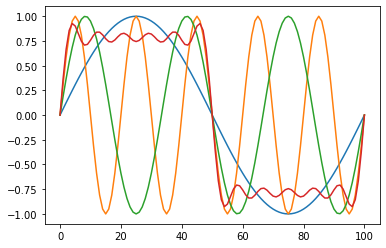

In [ ]:
w1 = np.linspace(0, 2 * np.pi, 101)
k = np.arange(12)
w = np.array([w1]).T @ np.array([k])
S = np.sin(w)
plt.plot(S[:, 1])
plt.plot(S[:, 3])
plt.plot(S[:, 5])

f = [0, 1, 0, 1/3, 0, 1/5, 0, 1/7, 0, 1/9, 0, 1/11]
x = S @ f
plt.plot(x)

Complex Sinusoid

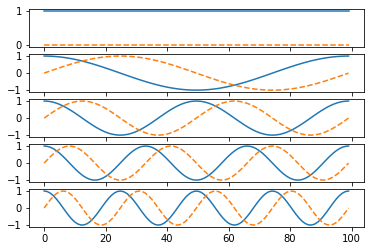

In [ ]:
fig = plt.figure()
x = np.linspace(0, 2*np.pi, 100)
for b in range(5):
    ax = fig.add_subplot(5, 1, b+1)
    plt.plot(np.cos(b*x), '-', np.sin(b*x), '--')

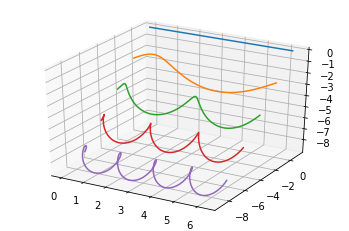

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
w = np.linspace(0, 2*np.pi, 100)
for k in range(5):
    f = np.exp(k * 1j * w)
    plt.plot(np.real(f) - 2*k, np.imag(f) - 2*k, w, zdir='x')

N=12 的 DFT 矩阵

In [17]:
N = 12
k = np.arange(N)
print(k)
nk = np.array([k]).T * k
print(nk)
F = np.exp(-1j*2*np.pi*nk/N)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   2   3   4   5   6   7   8   9  10  11]
 [  0   2   4   6   8  10  12  14  16  18  20  22]
 [  0   3   6   9  12  15  18  21  24  27  30  33]
 [  0   4   8  12  16  20  24  28  32  36  40  44]
 [  0   5  10  15  20  25  30  35  40  45  50  55]
 [  0   6  12  18  24  30  36  42  48  54  60  66]
 [  0   7  14  21  28  35  42  49  56  63  70  77]
 [  0   8  16  24  32  40  48  56  64  72  80  88]
 [  0   9  18  27  36  45  54  63  72  81  90  99]
 [  0  10  20  30  40  50  60  70  80  90 100 110]
 [  0  11  22  33  44  55  66  77  88  99 110 121]]


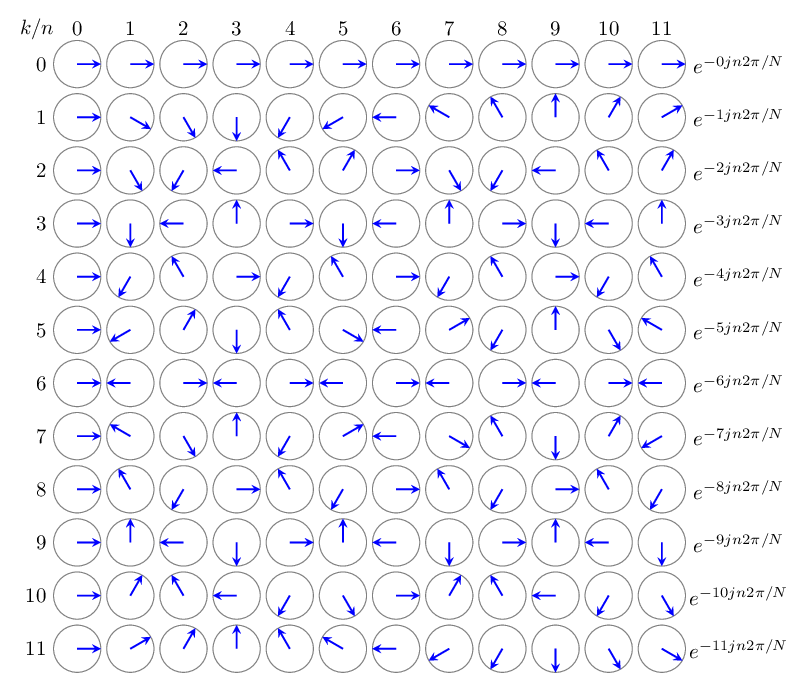

In [19]:
@interact(pos=(0, 11, 1))
def impluse(pos):
  plt.figure(figsize=(15,5))
  x = np.zeros(12)
  x[pos] = 1
  dft = F @ x
  plt.subplot(121)
  draw_resp_stem(np.real(dft), np.imag(dft))
  plt.subplot(122, projection='polar')
  plt.stem(np.angle(dft), np.abs(dft), use_line_collection=True)
  plt.ylim(0, 1.2)
  Y = np.fft.fft(x)
  assert np.allclose(dft, Y)

interactive(children=(IntSlider(value=5, description='pos', max=11), Output()), _dom_classes=('widget-interact…

In [20]:
@interact(freq=(0, 5, 0.2), phi=(-1, 1, 0.1))
def update(freq=1, phi=0):
    w = np.arange(128) * 2 * np.pi / 128
    x = 1*np.sin(freq*w + phi*np.pi)
    fft=np.fft.rfft(x)[0:16]/64

    plt.subplot(122, projection='polar')
    plt.stem(np.angle(fft), np.abs(fft), use_line_collection=True)

    plt.subplot(221)
    plt.plot(w, x)
    plt.ylim(-1.1, 1.1)

    plt.subplot(223)
    plt.stem(np.abs(fft), use_line_collection=True)
    plt.ylim(-0.1,1.1)


interactive(children=(FloatSlider(value=1.0, description='freq', max=5.0, step=0.2), FloatSlider(value=0.0, de…

### Peak detection and correction

Richard G. Lyons, _Understanding Digital Signal Processing 3/e_, 2011.

§ 13.15 Spectral Peak Location Algorithm

bin = 46.875 Hz


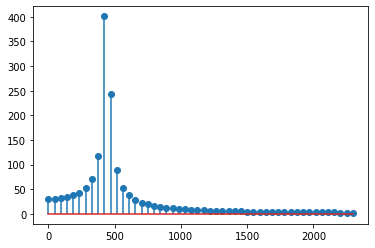

In [ ]:
fs = 48000
x = rosa.tone(440, sr=fs, duration=1)

nfft = 1024
fft = np.fft.rfft(x[0:nfft])
f = np.arange(50) * fs / nfft
plt.stem(f, np.abs(fft)[0:len(f)], use_line_collection=True)
print('bin = %.3f Hz' % (fs / nfft))

In [ ]:
# Naive max
m = np.argmax(np.abs(fft))
print("m = %d  f = %.3f Hz" % (m, m * fs / nfft))

m=9 f=421.875Hz


In [ ]:
# Correction using fomula (13-74) on page 733
X = fft
c = (X[m+1] - X[m-1]) / (2 * X[m] - X[m-1] - X[m+1])

print("%.3f Hz" % ((m-np.real(c)) * fs / nfft))

440.035Hz


### 频率分辨率和时间分辨率

FFT 的频率分辨率 $\dfrac{f_s}{N}$，时间分辨率 $\dfrac{N}{f_s}$

$X[k]$ 里每个点对应的是哪个频率？

* $X[0]$ 是 DC, 0 Hz
* $X[1]$ 是 Fs / N (Hz)
* $X[2]$ 是 2 * Fs / N (Hz)
* $X[N/2]$ 是 Fs / 2，如果抗混叠比较给力，这个数通常接近 0
* $k > N/2$ 通常不必关心

例子
* Fs = 8000 Hz, N = 1024, bin = 7.8 Hz, len = 128 ms
* Fs = 8000 Hz, N = 512, bin = 15.6 Hz, len = 64 ms
* Fs = 44100 Hz, N = 1024, bin = 43.1 Hz, len = 23 ms
* Fs = 44100 Hz, N = 2048, bin = 21.5 Hz  (Middle C = 262 Hz, D = 294 Hz), len = 46 ms
* Fs = 500 Hz, N = 256, bin = 1.95 Hz, 512 ms


### 对称性与信息守恒

$n$ 次多项式方程有 $n$ 个根（重根视为多个根）。如果系数是实数，那么根关于实轴对称。传递函数 $H(z)$ 的零极点分布满足这一规律。

2 次方程 $x^2+bx+c=0$ 有 2 个实系数 $b, c$， 有二根 $x_1, x_2=\dfrac{-b\pm\sqrt{b^2-4c}}{2}$

在 $b^2-4c > 0$ 时有 2 个实根，根的位置由两个实数 $x_1, x_2$ 表示。

在 $b^2-4c < 0$ 时 有两个复根，看起来有坐标是 4 个实数，但是由于 $x_1=\overline{x_2}$，根的位置也由两个实数表示 $\mathfrak{Re}(x_1), \mathfrak{Im}(x_1)$。信息量（2个实数）不变。

FFT 也不会改变信息量。输入实信号 $x[n]$ 有 $N$ 个点（实数），$X[k] = FFT(\boldsymbol x)$ 有 $N$ 个点（复数），看起来数字多了一倍，但是 $x[n]$ 和 $X[k]$ 包含相同的信息。

对于 $N$ 是偶数的情况，$X[k] = \overline{X[N-k]}$ for $1\le k < \dfrac{N}{2}$，
所以 $X[k]$ 有 $\dfrac{N}{2}+1$ 个独立的复数 (NumPy `fft.rfft()`）。进一步，$X[0]$ 和 $X[\frac{N}{2}]$ 是实数。所以 $X[k]$ 的信息完全由 $N$ 个实数确定。

以 $x[n]$ 为实数且 $N=10$ 为例，看上去 $X[k]$ 有 $N$ 个复数，即 $2N$ 个实数。仔细看，
$X[0]$ 和 $X[5]$ 都肯定是实数，因为 DFT 矩阵第 0 行全是 1，所以 $X[0]=\sum x[n]$。
DFT 矩阵第 $\frac{N}{2}=5$ 行是 [1 -1 1 -1 1 -1 ...]，所以 $X[5]=x[0]-x[1]+x[2]-x[3]+x[4]-x[5]+\cdots$ 也是实数。

由对称性 $X[1] = \overline{X[9]}$, $X[2] = \overline{X[8]}$, ..., $X[4] = \overline{X[6]}$，所以 $X[1], X[2], X[3], X[4]$ 的 8 个实数就表示了余下的信息。加上 $X[0]$ 和 $X[5]$ 一共刚好是 10 个数，不多不少跟 $x[n]$ 一样。

有些原地 (in-place) 的 Real FFT 会把 $X[N/2]$ 的实部放到 $X[0]$ 的虚部所在的位置，这刚好不用额外分配空间。

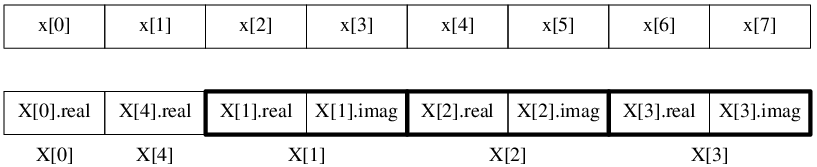

Ffmpeg `av_rdft_calc()` 正是如此，但其文档对此只字未提 https://ffmpeg.org/doxygen/4.1/avfft_8h_source.html 

### Summary

“FFT 能用来干什么” 和“如何高效计算 FFT”是两个问题，应该由不同的人去研究。作为搞信号处理的学生，我认为应该把主要精力集中在前者，而让数学家和 CS 体系结构的人去攻坚后者。一些 DSP 课程花了很多精力去讲 FFT 的蝶形运算，学生学得云里雾里，在我看来是本末倒置。这个算法确实很优雅很巧妙，但是对于广大用到 DSP 的人士，知道在哪里能找到合适的 fft 库就足够了，实在没必要每个人去自己实现 `fft()`。现在用 CMSIS DSP 库可以很方便地在 ARM 的 M4/M7 等单片机上算 FFT，在 JavaScript 里做 FFT 也不是什么新鲜事儿了。

* https://community.vcvrack.com/t/complete-list-of-c-c-fft-libraries/9153
* http://www.fftw.org (Scientific)
* FFMpeg libcodec av_fft (float32 for audio/video)
* SciPy.fft and NumPy.fft (convenient)
* ARM white paper - DSP capabilities of Cortex-M4 and Cortex-M7
* https://github.com/ARM-software/CMSIS_5 (embedded)
* https://cr.yp.to/djbfft.html (historical)
* https://netlib.org/fftpack/ (historical)

我看见不少人学 DSP，包括当年的我自己，最后就是自己写（照书抄）了一个 `fft()` 例程，拿来实现了一把快速卷积，再照猫画虎设计了一个 FIR 滤波器和一个 IIR 滤波器就完事儿了，这是丢了西瓜捡了芝麻。

https://zhuanlan.zhihu.com/p/19763358

http://dsp-book.narod.ru/TDCH/CH-02.PDF

https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/

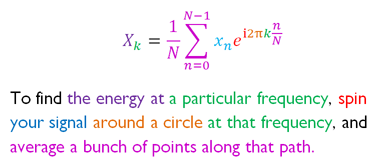

## Spectrogram

# Lab5: Sampling, alias, modulation

https://www.youtube.com/watch?v=cIQ9IXSUzuM (D/A and A/D)

https://www.youtube.com/watch?v=OQNR099y8mM (Alan Oppenheim)

https://www.youtube.com/watch?v=2wO8ZHnn3Q4 (Richard Hamming)

https://www.engr.colostate.edu/ECE423/course_info.shtml DSP for Communications

# Lab6: Advanced

https://en.wikipedia.org/wiki/Audio_time_stretching_and_pitch_scaling

## Heartbeat rate from camera

Berkeley EE120 Lab4

https://github.com/dominiccarrano/ee-120-labs/blob/master/lab4/lab4.ipynb